In [1]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from coffea import processor 
from coffea.util import load, save
import hist
import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
from cycler import cycler
import math

## work in progress

In [3]:
year='2018'
hists = load('../hists/bbww'+year+'.scaled')

In [4]:
data_hists   = hists['data']
bkg_hists    = hists['bkg']
signal_hists = hists['sig']

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x16c8a4410>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

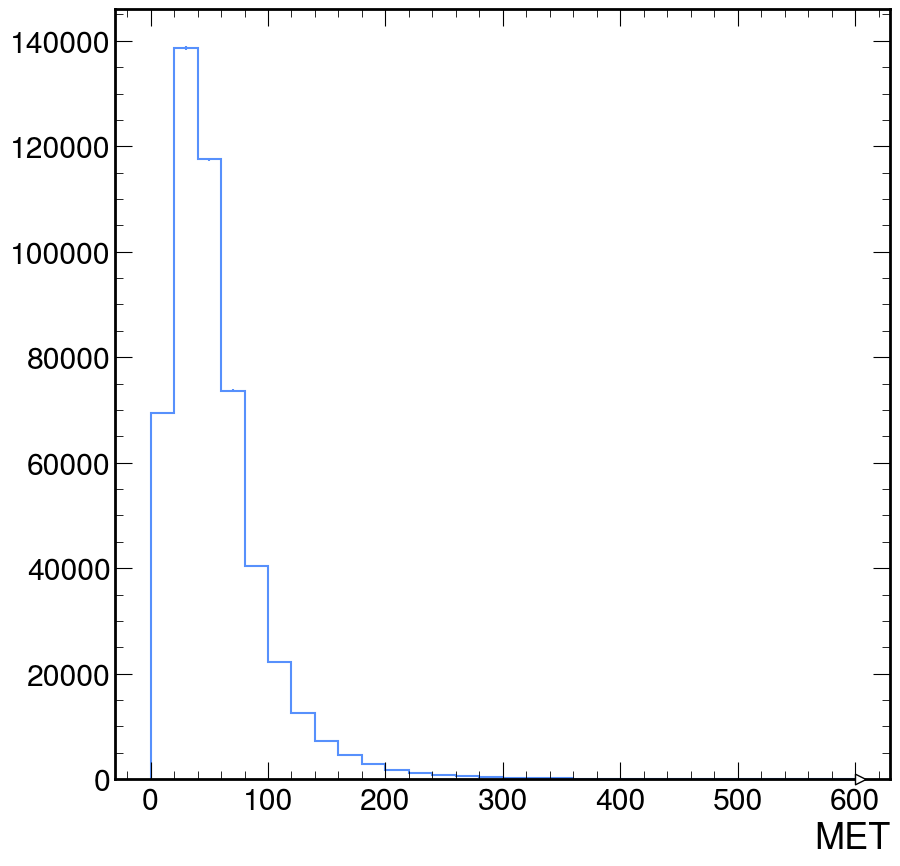

In [5]:
data_hists['met']['EGamma'].plot1d()

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x302cd3650>, cbar=<matplotlib.colorbar.Colorbar object at 0x30a2f0260>, text=[])

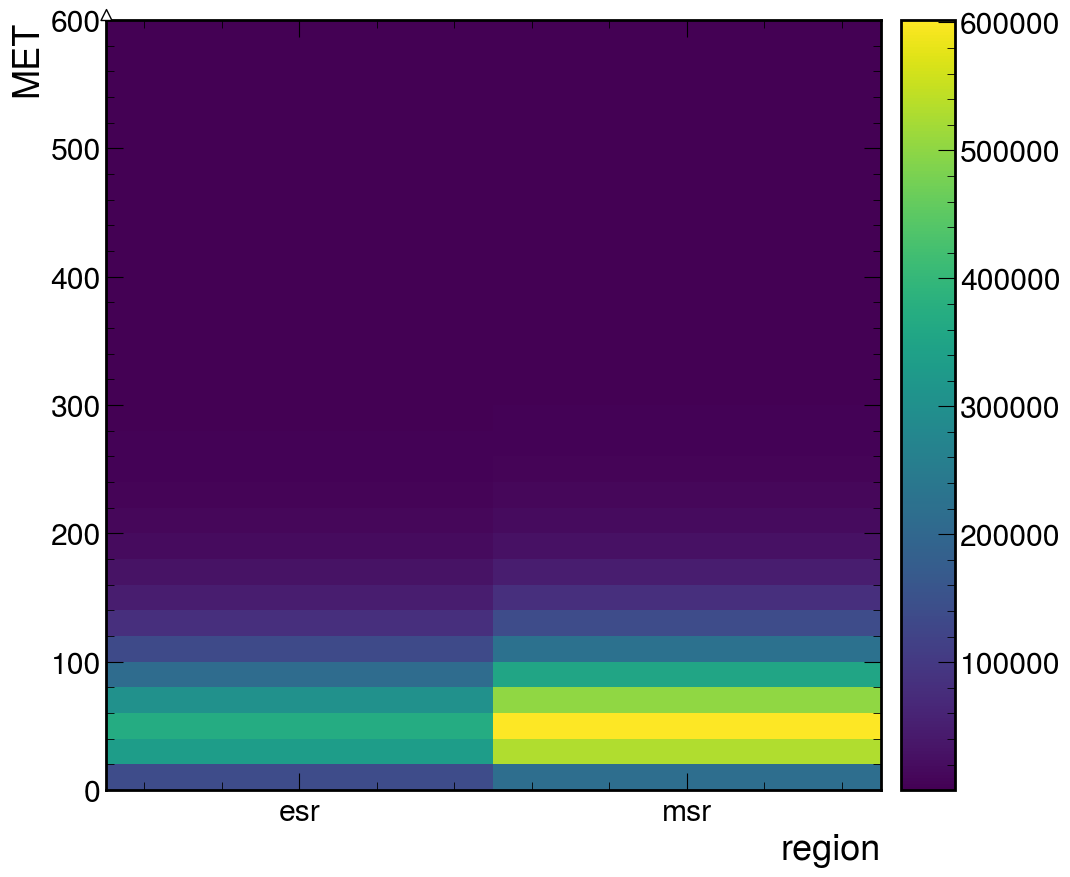

In [6]:
bkg_hists['met']['TT'].plot2d()

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x16cdb66c0>, cbar=<matplotlib.colorbar.Colorbar object at 0x30aa9a3f0>, text=[])

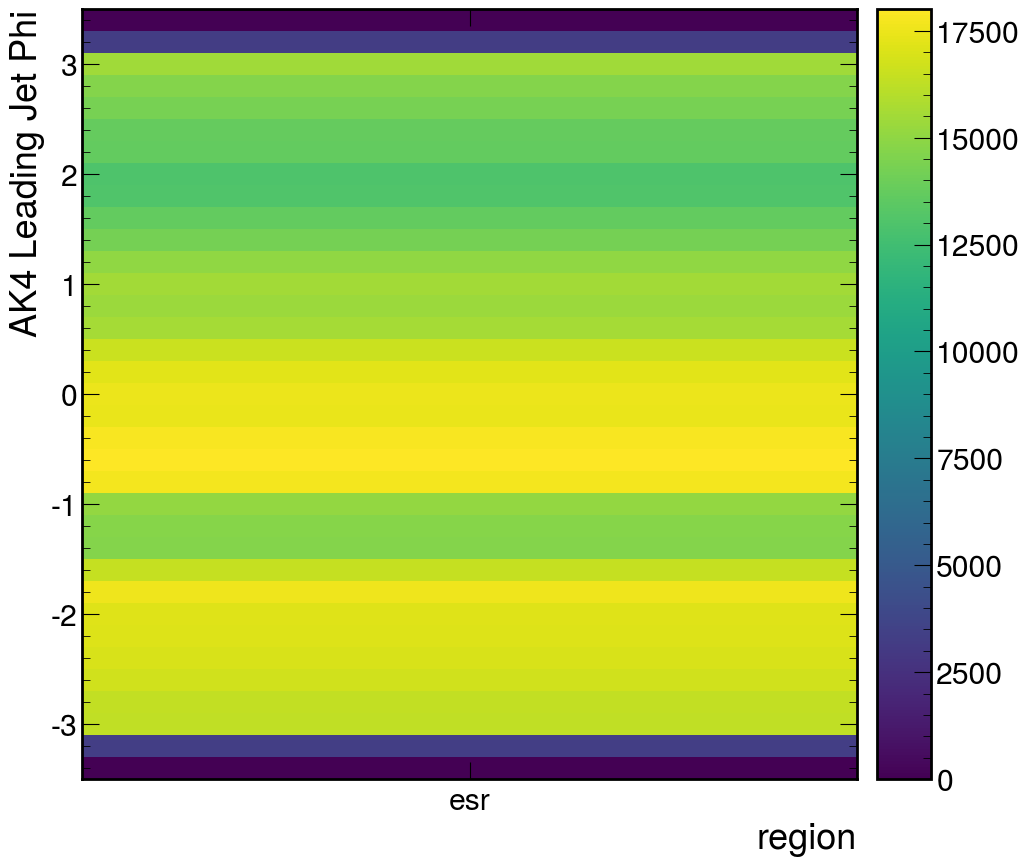

In [7]:
data_hists['j1phi']['EGamma'].plot2d()

In [8]:
lumis = { 
    #Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVDatasetsUL2016                                                      
    '2016postVFP': 19.5,
    '2016preVFP': 16.8,
    '2017': 41.48,
    '2018': 59.83
    }
lumi=lumis[year]

In [9]:
data={
    '2016preVFP':{
        'msr': 'SingleMuon',
        'esr': 'SingleElectron'
    },
    '2016postVFP':{
        'msr': 'SingleMuon',
        'esr': 'SingleElectron'
    },
    '2017':{
        'msr': 'SingleMuon',
        'esr': 'SingleElectron'
    },
    '2018':{
        'msr': 'SingleMuon',
        'esr': 'EGamma'
    }
}

In [10]:
# to replicated the outdated rebin call
# taken from kdlong at https://gist.github.com/kdlong/d697ee691c696724fc656186c25f8814
def rebin_hist(h, axis_name, edges):
    if type(edges) == int:
        return h[{axis_name : hist.rebin(edges)}]

    ax = h.axes[axis_name]
    ax_idx = [a.name for a in h.axes].index(axis_name)
    if not all([np.isclose(x, ax.edges).any() for x in edges]):
        raise ValueError(f"Cannot rebin histogram due to incompatible edges for axis '{ax.name}'\n"
                            f"Edges of histogram are {ax.edges}, requested rebinning to {edges}")
        
    # If you rebin to a subset of initial range, keep the overflow and underflow
    overflow = ax.traits.overflow or (edges[-1] < ax.edges[-1] and not np.isclose(edges[-1], ax.edges[-1]))
    underflow = ax.traits.underflow or (edges[0] > ax.edges[0] and not np.isclose(edges[0], ax.edges[0]))
    flow = overflow or underflow
    new_ax = hist.axis.Variable(edges, name=ax.name, overflow=overflow, underflow=underflow)
    axes = list(h.axes)
    axes[ax_idx] = new_ax
    
    hnew = hist.Hist(*axes, name=h.name, storage=h._storage_type())

    # Offset from bin edge to avoid numeric issues
    offset = 0.5*np.min(ax.edges[1:]-ax.edges[:-1])
    edges_eval = edges+offset
    edge_idx = ax.index(edges_eval)
    # Avoid going outside the range, reduceat will add the last index anyway
    if edge_idx[-1] == ax.size+ax.traits.overflow:
        edge_idx = edge_idx[:-1]

    if underflow:
        # Only if the original axis had an underflow should you offset
        if ax.traits.underflow:
            edge_idx += 1
        edge_idx = np.insert(edge_idx, 0, 0)

    # Take is used because reduceat sums i:len(array) for the last entry, in the case
    # where the final bin isn't the same between the initial and rebinned histogram, you
    # want to drop this value. Add tolerance of 1/2 min bin width to avoid numeric issues
    hnew.values(flow=flow)[...] = np.add.reduceat(h.values(flow=flow), edge_idx, 
            axis=ax_idx).take(indices=range(new_ax.size+underflow+overflow), axis=ax_idx)
    if hnew._storage_type() == hist.storage.Weight():
        hnew.variances(flow=flow)[...] = np.add.reduceat(h.variances(flow=flow), edge_idx, 
                axis=ax_idx).take(indices=range(new_ax.size+underflow+overflow), axis=ax_idx)
    return hnew

In [11]:
exp = 0
exp_unc = 0
tot_bkg_yld_array={():0}
region = 'esr'
sys='nominal'

In [12]:
bkg_map = OrderedDict()
bkg_map[r"$t\bar{t}$"] = (["TT"],)

In [13]:
print('Region:', region)


Region: esr


In [14]:
bkg_hists_table=bkg_hists['met']
data_hists_table=data_hists['met']

In [15]:
for p in bkg_map.keys():
    for sample in bkg_map[p][0]:
        bkg_yld_array = bkg_hists_table[sample][{'region':region}].view()
        print(bkg_yld_array)
        print(type(bkg_hists_table[sample][{'region':region}]))

WeightedSumView: (value, variance)
[(1.37763681e+05, 2.07122993e+04) (3.33262156e+05, 5.05983344e+04)
 (3.70151105e+05, 5.72806998e+04) (3.02122423e+05, 4.80875439e+04)
 (2.10553161e+05, 3.45171307e+04) (1.34111418e+05, 2.25476719e+04)
 (8.20866824e+04, 1.40636990e+04) (4.87502319e+04, 8.44590449e+03)
 (2.89340402e+04, 5.04410332e+03) (1.73540770e+04, 3.03200931e+03)
 (1.04484183e+04, 1.82595169e+03) (6.44997050e+03, 1.12202649e+03)
 (4.09026426e+03, 7.16231064e+02) (2.65352685e+03, 4.64995293e+02)
 (1.70939563e+03, 2.99343385e+02) (1.18541205e+03, 2.08871464e+02)
 (8.03785741e+02, 1.42521838e+02) (5.60002243e+02, 9.93340297e+01)
 (3.96398115e+02, 7.03769441e+01) (2.87623964e+02, 5.21396223e+01)
 (2.06179610e+02, 3.72417967e+01) (1.57851379e+02, 2.85033749e+01)
 (1.10057486e+02, 1.93724562e+01) (8.80027957e+01, 1.64728793e+01)
 (7.34767774e+01, 1.34110782e+01) (5.27041721e+01, 1.00276614e+01)
 (4.07103639e+01, 7.38326860e+00) (3.30768691e+01, 6.06930288e+00)
 (2.66636373e+01, 5.1811276

In [16]:
for p in bkg_map.keys():
    for sample in bkg_map[p][0]:
        try:
            bkg_yld_array = bkg_hists_table[sample][{'region':region}].view()
            yld_stats = bkg_yld_array[:].sum()
            yld = yld_stats.value
            unc = yld_stats.variance
            tot_bkg_yld_array[()]+=bkg_yld_array
            exp += yld
            exp_unc += unc
        except KeyError as e:
            # the 'sumw' key is not a histogram
            if 'yld' not in locals():
                yld = 0;
                unc = 0;
    print(p, '%.1f' % yld, '$\\pm$', '%.1f' % np.sqrt(unc))

print('------------------------')
print('Total expected:', '%.1f' % exp, '$\\pm$', '%.1f' % np.sqrt(exp_unc))
print('------------------------')
        

$t\bar{t}$ 1694480.4 $\pm$ 519.1
------------------------
Total expected: 1694480.4 $\pm$ 519.1
------------------------


In [17]:
###
# To optimize cuts based on process yield, i.e. you wanna test some background rejection
###

exp = 0
region = 'esr'

variable = 'met'
cut_bin = 2 #0

met_axis_index = 1
cut_value_array = data_hists[variable]['EGamma'].axes[met_axis_index].edges
nbins = cut_value_array.shape[0]-1

print('------------------------')
print('------------------------')
print('Region:', region)
#print('------------------------')
if cut_bin!=None: print(variable,'> %.2f' % cut_value_array[()][cut_bin+1])
print('------------------------')
print('------------------------')
for p in bkg_hists[variable].keys():
    try:
        yld_array = bkg_hists[variable][p][{'region':region}].values()

        yld = yld_array[:].sum()
        if cut_bin!=None: yld = yld - np.cumsum(yld_array[:])[cut_bin]

        exp += yld
        print(p, '%.1f' % yld)
    except KeyError as e:
        # the 'sumw' key is not a histogram
        pass

print('------------------------')
print('Total expected:', '%.1f' % exp)
print('------------------------')

for p in signal_hists[variable].keys():
    yld_array = signal_hists[variable][p][{'region':region}].values()
    yld = yld_array[:].sum()
    if cut_bin!=None: yld = yld - np.cumsum(yld_array[:])[cut_bin]

    print(p,'          %.1f' %  yld)
    print(p,'S/B       %.3f' % (yld/exp))
    print(p,'S/sqrt(B) %.1f' % (yld/np.sqrt(exp)))

    print('------------------------')

if not region == '':
    yld_array = data_hists[variable][data[year][region]][{'region':region}].values()

    yld = yld_array[:].sum()
    if cut_bin!=None: yld = yld - np.cumsum(yld_array[:])[cut_bin]

    print('Total observed:', '%.1f' % yld)   
print('------------------------')
print()

------------------------
------------------------
Region: esr
met > 60.00
------------------------
------------------------
TT 853303.4
------------------------
Total expected: 853303.4
------------------------
Total observed: 169044.0
------------------------



NameError: name 'labels' is not defined

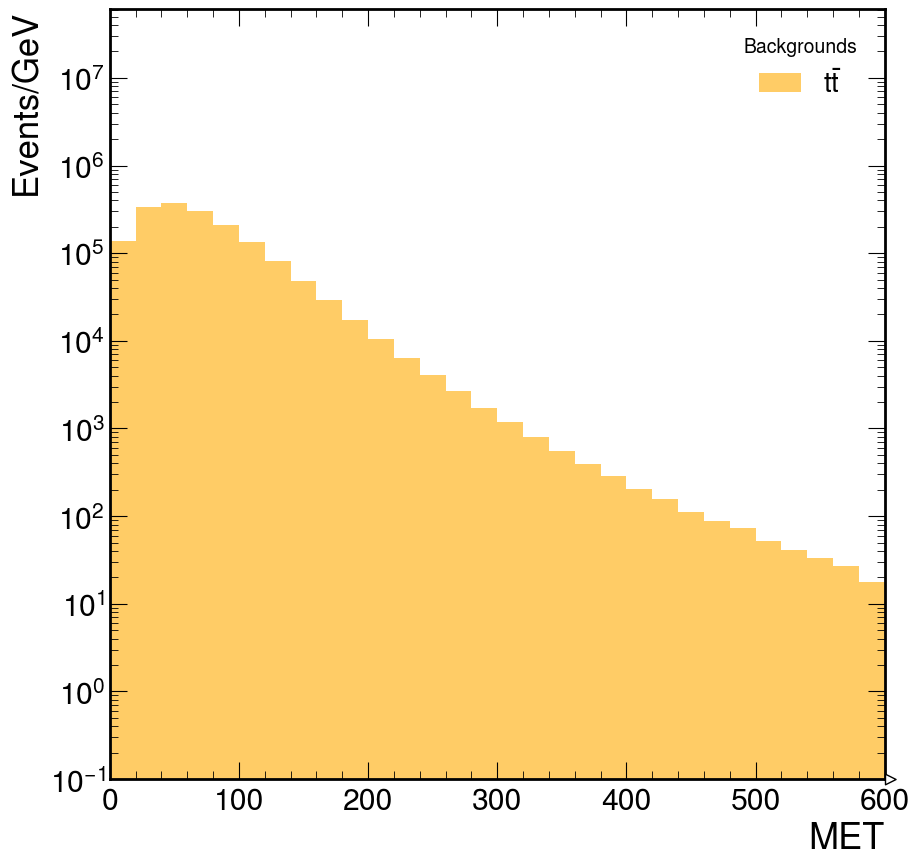

In [18]:
colorDict = {
    'DY+jets': '#e5ccff',
    r'$H\rightarrow b\bar{b}$':'#ccccff',
    'QCD': '#ffccff',
    'Diboson': '#ffff99',
    'Single t': '#ff9999',
    r"$t\bar{t}$": '#ffcc66',
    'W+jets': '#ccffcc',
    'Z+jets':'#99ffff'
}
bkg_map = OrderedDict()
bkg_map['TT'] = r"$t\bar{t}$"
for variable in bkg_hists.keys():
    
    if variable=='sumw': continue
    if variable=='ndflvM': continue
    if variable == 'njets': continue
    #print(bkg_hists[variable], type(bkg_hists[variable]))
    for process in bkg_hists[variable].keys():
        #print(process)
        bkg_hist_var = bkg_hists[variable][process]
        #print(bkg_hist_var, type(bkg_hist_var))
        idx =0
        for region in bkg_hist_var.axes['region']:
            idx+=1
            
            error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
            fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
            nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
            data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
            #for i in bkg_map.keys():
                #colors.append(colorDict[bkg_map[i]])
            #colors.reverse()
            
            colors = ['#99ffff', '#ccffcc', '#ffcc66', '#ff9999', '#ffff99', '#ffccff', '#ccccff','#e5ccff']
            hep.style.use("CMS")
            fig, ax = plt.subplots()
            fig.subplots_adjust(hspace=.07)
            plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
            plt.rcParams['text.usetex'] = False
            ax.set_prop_cycle(cycler(color=colors))
            bkg_hist_var[{'region':region}].plot1d(ax = ax, stack=True, histtype='fill', sort = 'label', color = '#ffcc66')
            ax.legend([r'$t\bar{t}$'], title='Backgrounds', fontsize=20)
            ax.set_ylabel('Events/GeV',fontsize=25)
            #ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
            ax.autoscale(axis='x', tight=True)
            ax.set_yscale('log')
            ax.set_ylim(.1, ax.get_ylim()[1]*100.)
            #order = list(range(len(labels)-1))
            #order.insert(0, len(labels)-1)
            #ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                 #loc='upper right', fontsize=12, ncol=2)
            if 'esr' in str(region):
                ax.text(s = 'Electron Signal Region', x = 0.05, y = 0.95, transform = ax.transAxes, fontsize = 16)
            if 'msr' in str(region):
                ax.text(s = 'Muon Signal Region', x = 0.05, y = 0.95, transform = ax.transAxes, fontsize = 16)
            hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)
            #hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=25)
            plt.show()
            if idx ==2:break
        
        



In [ ]:
colorDict = {
    'DY+jets': '#e5ccff',
    r'$H\rightarrow b\bar{b}$':'#ccccff',
    'QCD': '#ffccff',
    'Diboson': '#ffff99',
    'Single t': '#ff9999',
    r"$t\bar{t}$": '#ffcc66',
    'W+jets': '#ccffcc',
    'Z+jets':'#99ffff'
}
bkg_map = OrderedDict()
bkg_map['TT'] = r"$t\bar{t}$"
for variable in bkg_hists.keys():
    
    if variable=='sumw': continue
    if variable=='ndflvM': continue
    if variable == 'njets': continue
    #print(bkg_hists[variable], type(bkg_hists[variable]))
    for process in bkg_hists[variable].keys():
        #print(process)
        bkg_hist_var = bkg_hists[variable][process]
        #print(bkg_hist_var, type(bkg_hist_var))
        idx =0
        for region in bkg_hist_var.axes['region']:
            idx+=1
            
            error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
            fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
            nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
            data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
            #for i in bkg_map.keys():
                #colors.append(colorDict[bkg_map[i]])
            #colors.reverse()
            
            colors = ['#99ffff', '#ccffcc', '#ffcc66', '#ff9999', '#ffff99', '#ffccff', '#ccccff','#e5ccff']
            hep.style.use("CMS")
            fig, ax = plt.subplots()
            fig.subplots_adjust(hspace=.07)
            plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
            plt.rcParams['text.usetex'] = False
            ax.set_prop_cycle(cycler(color=colors))
            bkg_hist_var[{'region':region}].plot1d(ax = ax, stack=True, histtype='fill', sort = 'label', color = '#ffcc66')
            ax.legend([r'$t\bar{t}$'], title='Backgrounds', fontsize=20)
            ax.set_ylabel('Events/GeV',fontsize=25)
            #ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
            ax.autoscale(axis='x', tight=True)
            ax.set_yscale('log')
            ax.set_ylim(.1, ax.get_ylim()[1]*100.)
            order = list(range(len(labels)-1))
            order.insert(0, len(labels)-1)
            #ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                 #loc='upper right', fontsize=12, ncol=2)
            if 'esr' in str(region):
                ax.text(s = 'Electron Signal Region', x = 0.05, y = 0.95, transform = ax.transAxes, fontsize = 16)
            if 'msr' in str(region):
                ax.text(s = 'Muon Signal Region', x = 0.05, y = 0.95, transform = ax.transAxes, fontsize = 16)
            hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)
            #hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=25)
            plt.show()
            if idx ==2:break
        
        



In [94]:
data_hists['ndflvM']

{'EGamma': Hist(
   StrCategory(['esr'], growth=True, name='region'),
   IntCategory([0, 1, 2, 3, 4, 5, 6], name='ndflvM', label='AK4 Number of deepFlavor Medium Jets'),
   storage=Weight()) # Sum: WeightedSum(value=494694, variance=494694) (WeightedSum(value=494703, variance=494703) with flow)}

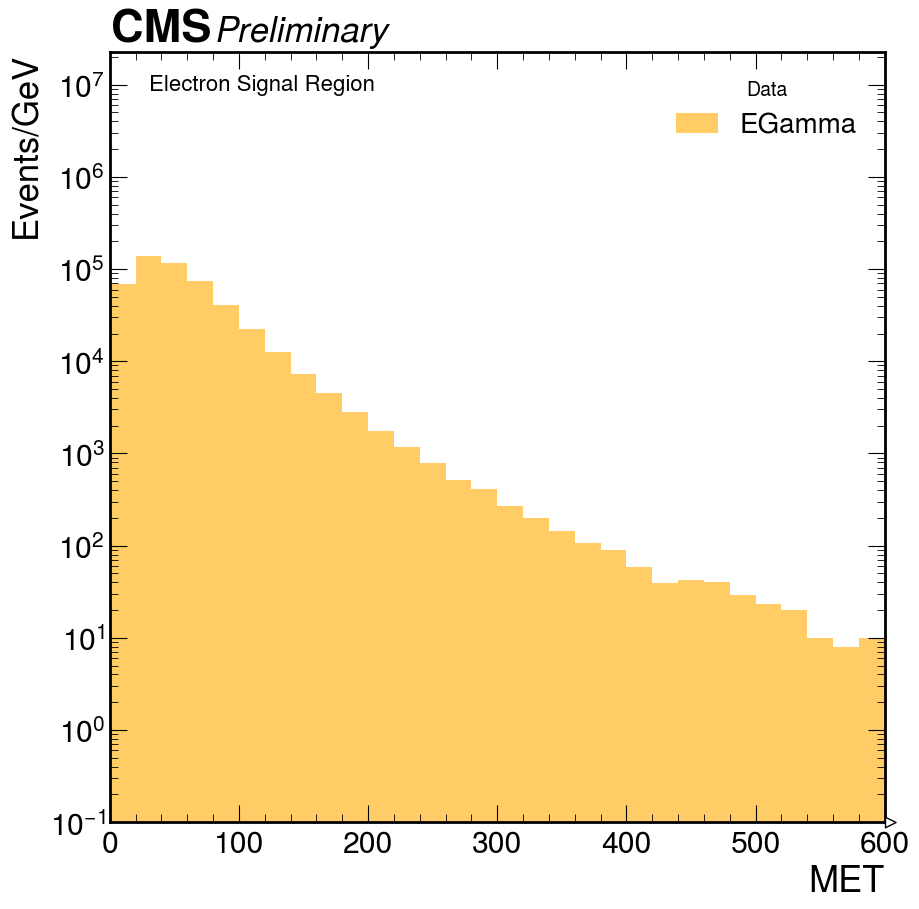

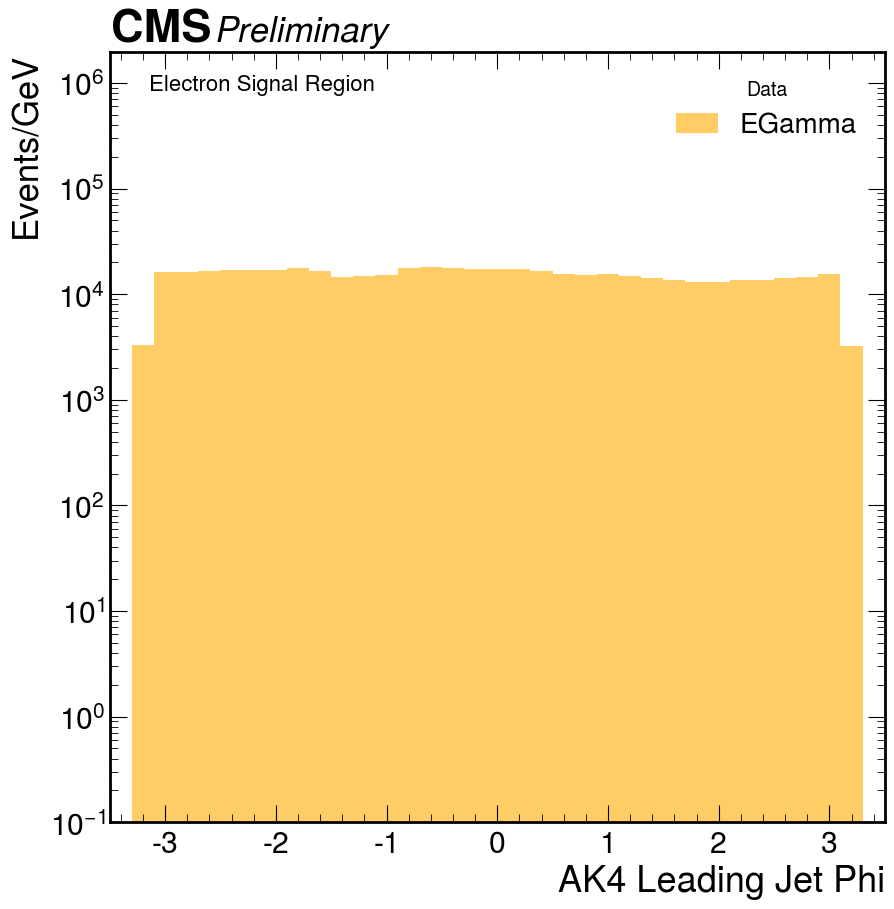

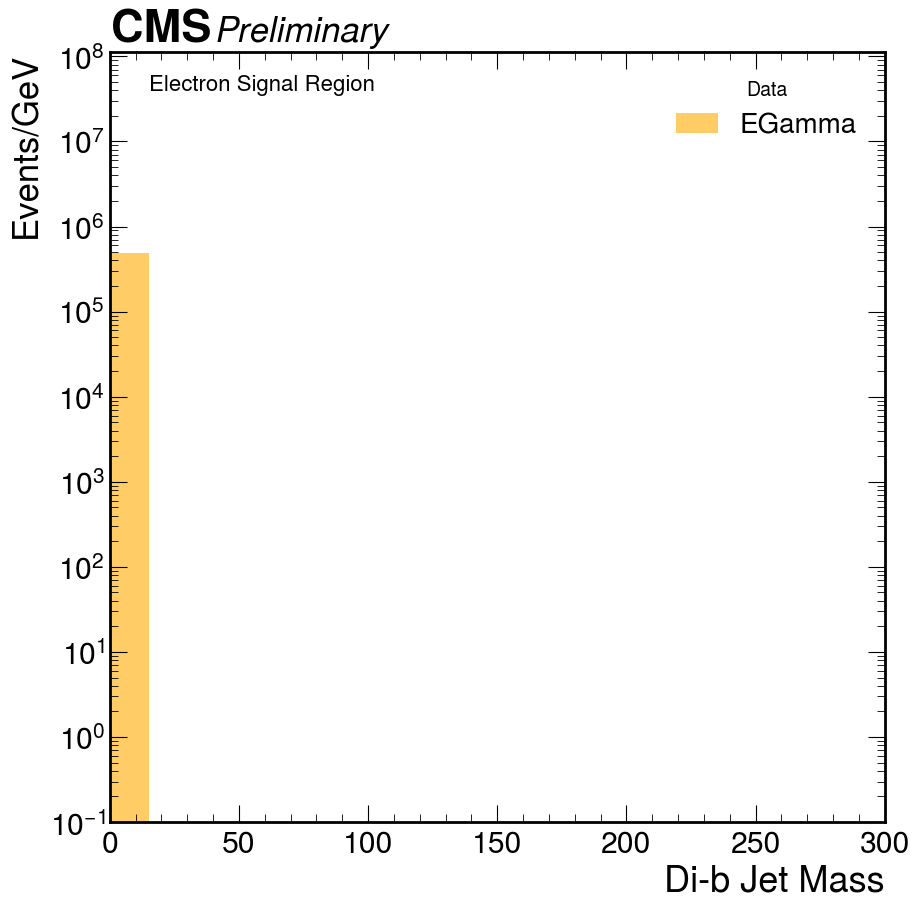

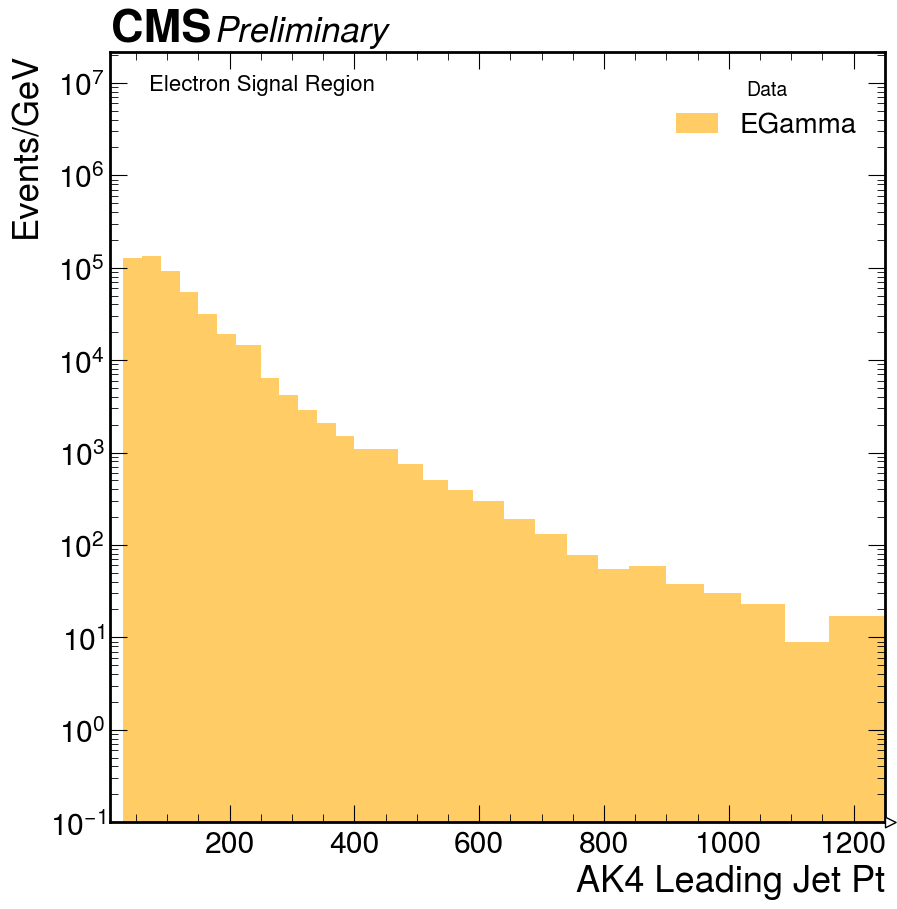

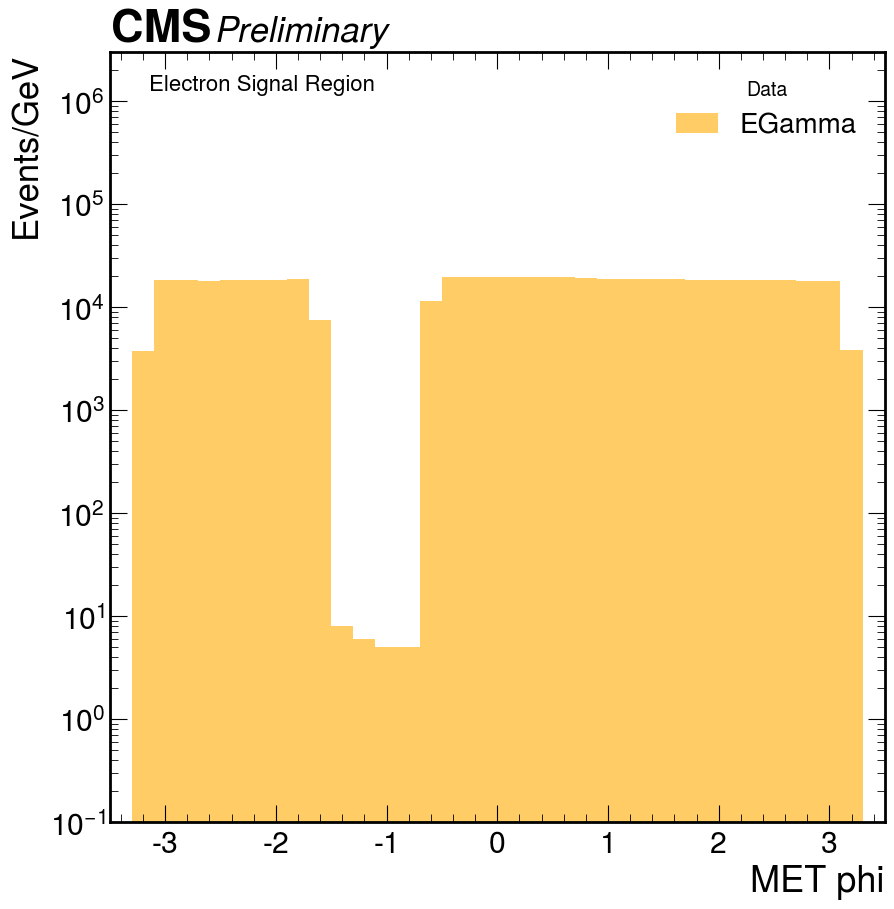

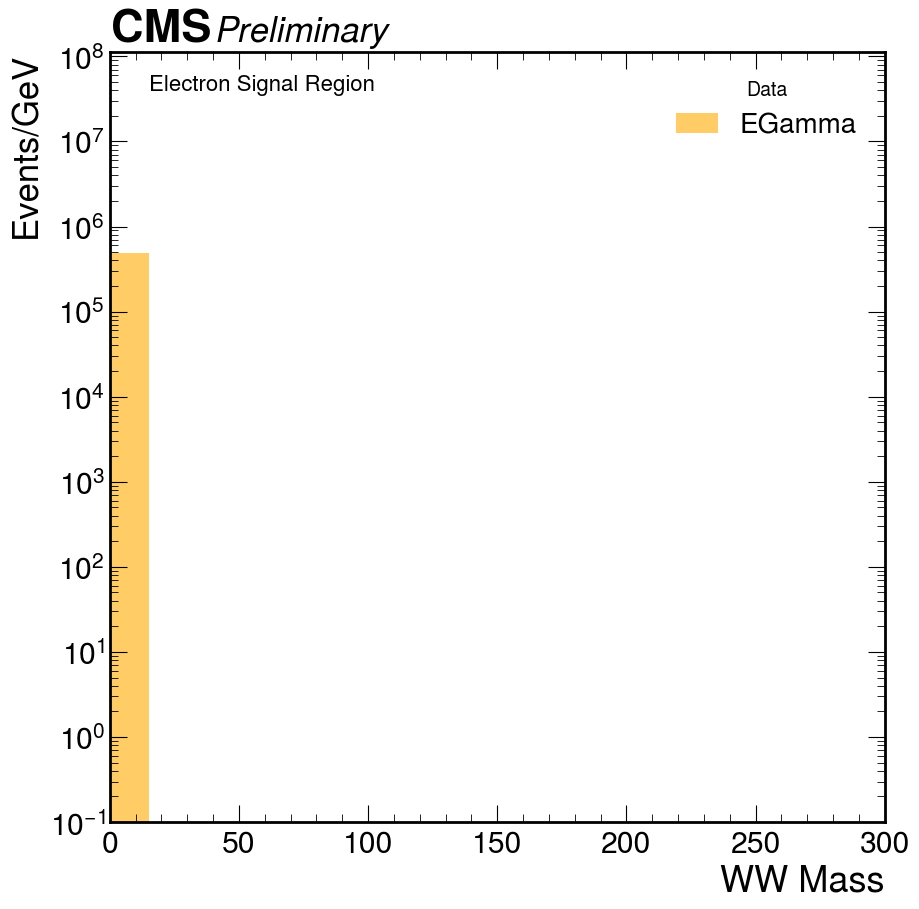

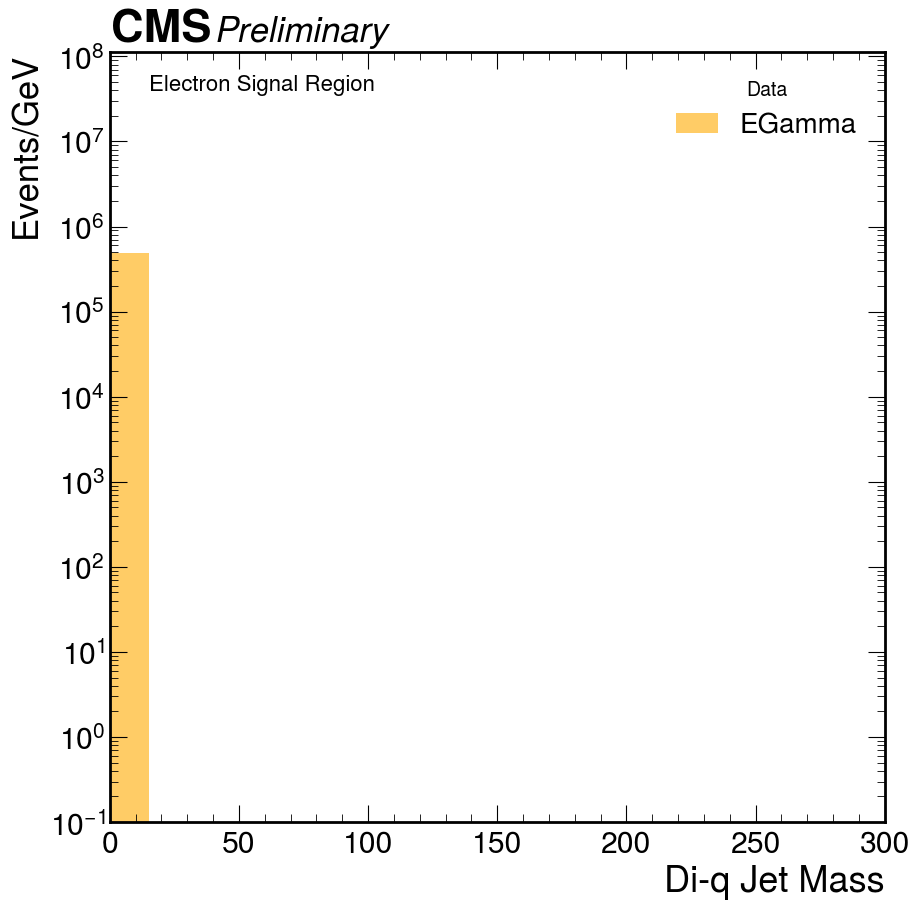

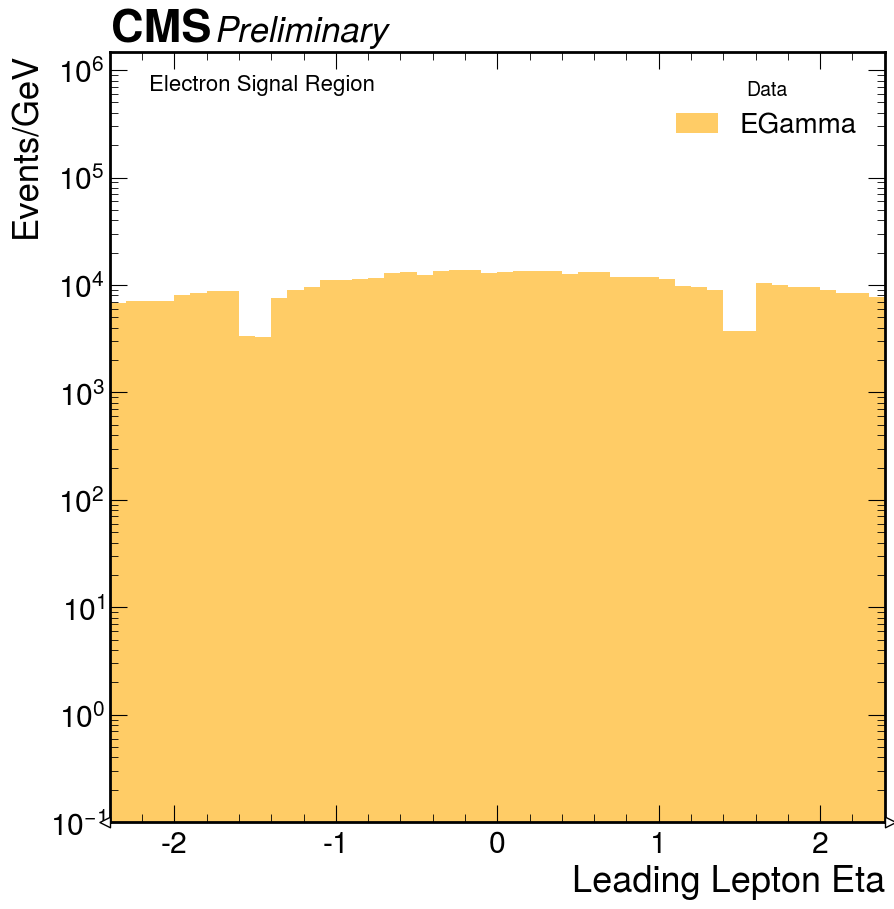

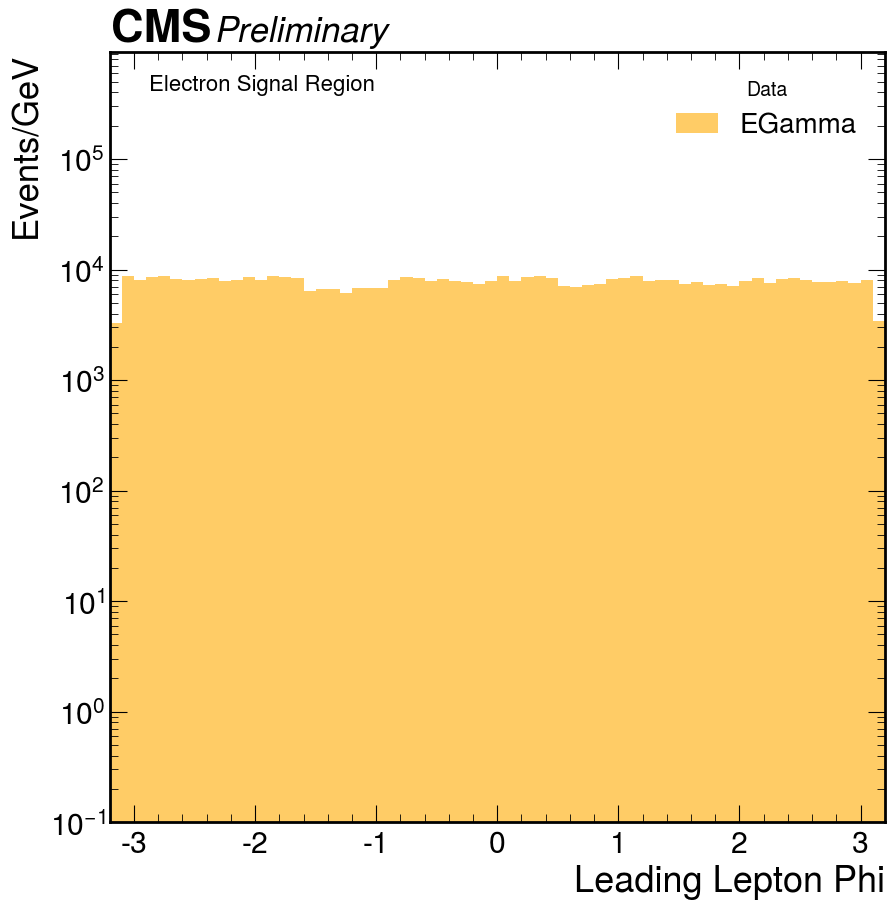

/var/folders/hj/t7nt9g255973s5cwl4skm39m0000gn/T/ipykernel_1912/1548298947.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


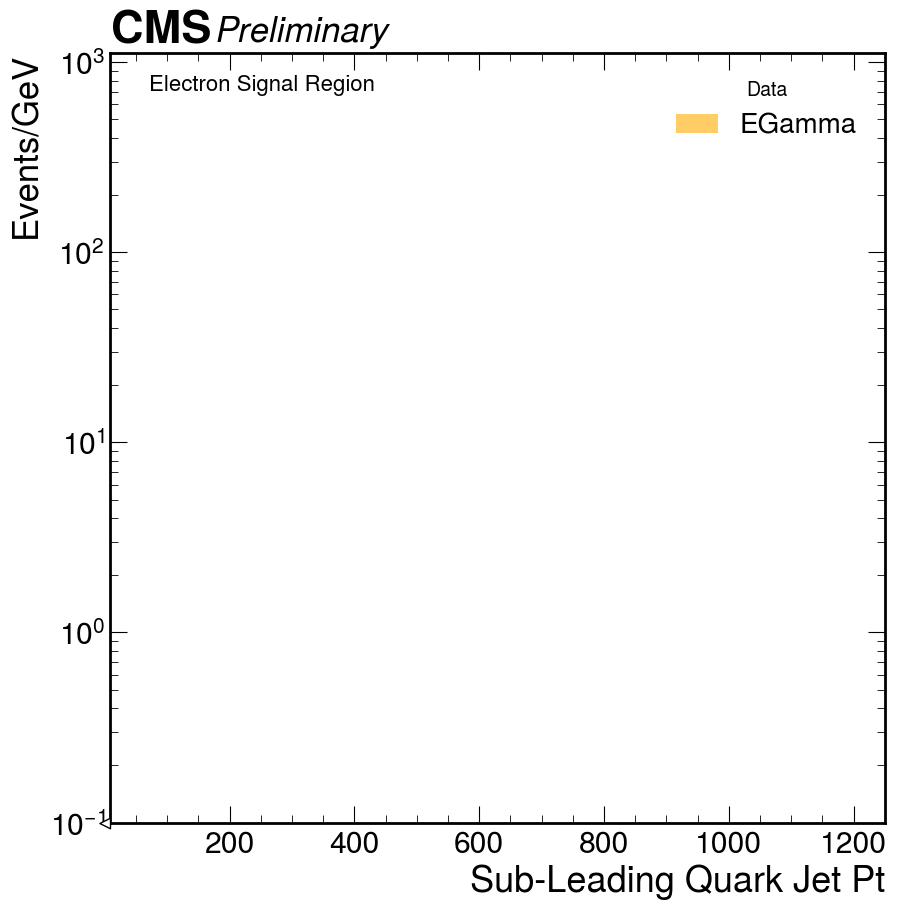

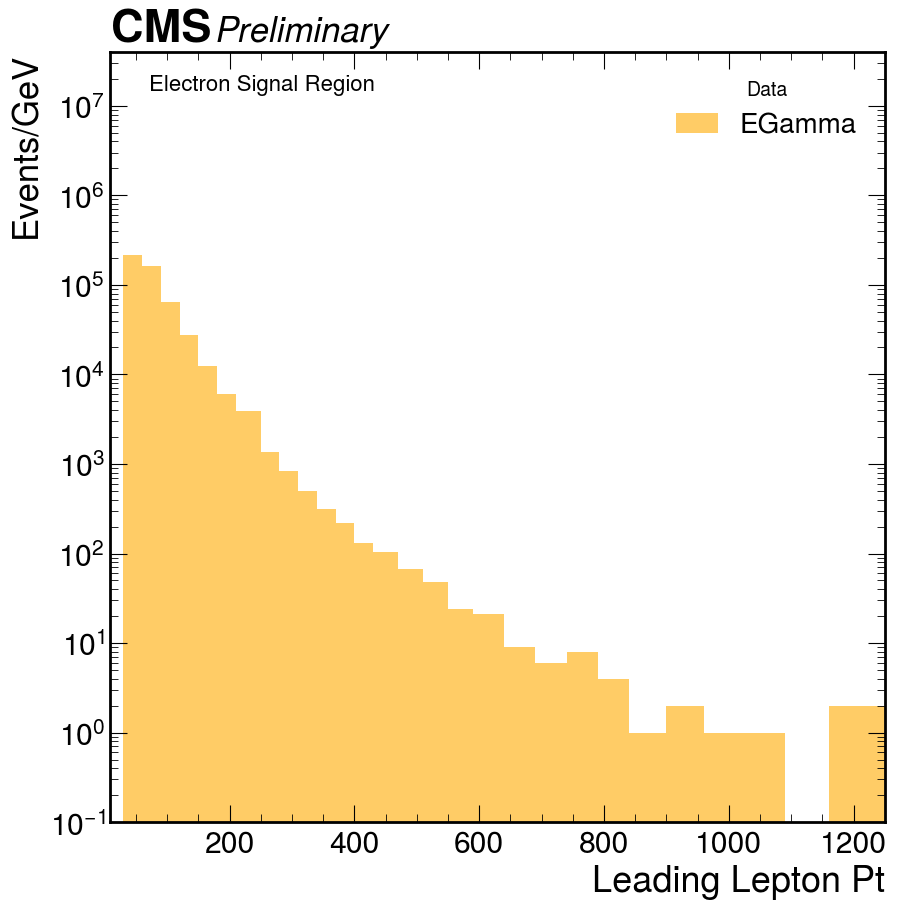

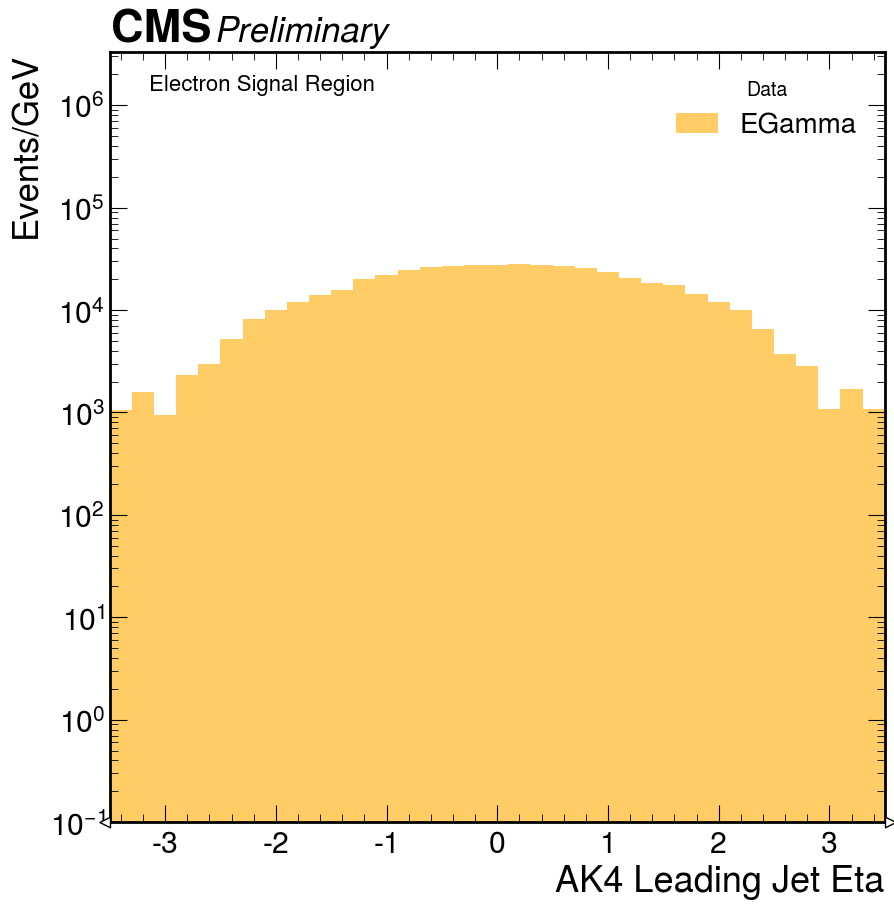

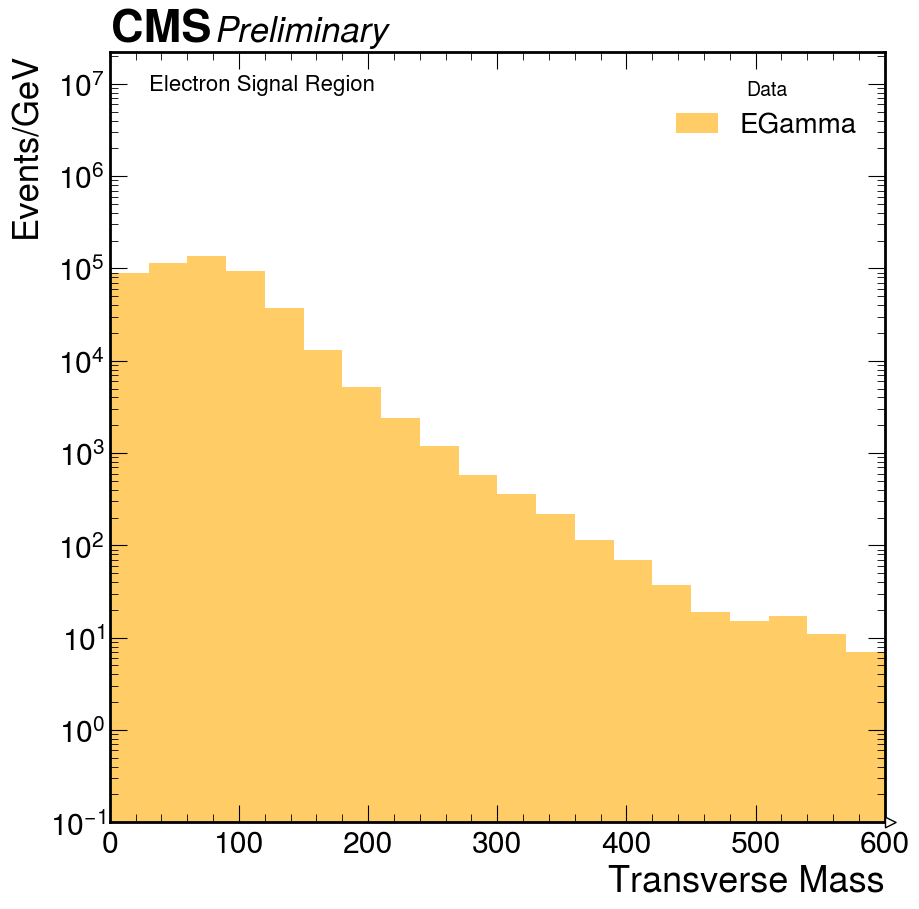

In [96]:
colorDict = {
    'DY+jets': '#e5ccff',
    r'$H\rightarrow b\bar{b}$':'#ccccff',
    'QCD': '#ffccff',
    'Diboson': '#ffff99',
    'Single t': '#ff9999',
    r"$t\bar{t}$": '#ffcc66',
    'W+jets': '#ccffcc',
    'Z+jets':'#99ffff'
}
bkg_map = OrderedDict()
bkg_map['TT'] = r"$t\bar{t}$"
for variable in data_hists.keys():
    
    if variable=='sumw': continue
    if variable=='ndflvM': continue
    if variable == 'njets': continue
    #print(bkg_hists[variable], type(bkg_hists[variable]))
    for process in data_hists[variable].keys():
        #print(process)
        data_hist_var = data_hists[variable][process]
        #print(bkg_hist_var, type(bkg_hist_var))
        idx =0
        for region in data_hist_var.axes['region']:
            idx+=1
            
            error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
            fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
            nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
            data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
            #for i in bkg_map.keys():
                #colors.append(colorDict[bkg_map[i]])
            #colors.reverse()
            
            colors = ['#99ffff', '#ccffcc', '#ffcc66', '#ff9999', '#ffff99', '#ffccff', '#ccccff','#e5ccff']
            hep.style.use("CMS")
            fig, ax = plt.subplots()
            fig.subplots_adjust(hspace=.07)
            plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
            plt.rcParams['text.usetex'] = False
            ax.set_prop_cycle(cycler(color=colors))
            data_hist_var[{'region':region}].plot1d(ax = ax, stack=True, histtype='fill', sort = 'label', color = '#ffcc66')
            ax.legend([process], title='Data', fontsize=20)
            ax.set_ylabel('Events/GeV',fontsize=25)
            #ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
            ax.autoscale(axis='x', tight=True)
            ax.set_yscale('log')
            ax.set_ylim(.1, ax.get_ylim()[1]*100.)
            order = list(range(len(labels)-1))
            order.insert(0, len(labels)-1)
            #ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                 #loc='upper right', fontsize=12, ncol=2)
            if 'esr' in str(region):
                ax.text(s = 'Electron Signal Region', x = 0.05, y = 0.95, transform = ax.transAxes, fontsize = 16)
            if 'msr' in str(region):
                ax.text(s = 'Muon Signal Region', x = 0.05, y = 0.95, transform = ax.transAxes, fontsize = 16)
            hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)
            #hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=25)
            plt.show()
            if idx ==2:break
        
        



In [23]:
def plot(year, hist_type, overlay=False):
    hists = load('../hists/bbww'+year+'.scaled')
    if hist_type == 'data':
        hists   = hists['data']
    if hist_type == 'bkg':
        hists    = hists['bkg']
    if hist_type == 'sig':
        hists = hists['sig']

    colorDict = {
    'DY+jets': '#e5ccff',
    r'$H\rightarrow b\bar{b}$':'#ccccff',
    'QCD': '#ffccff',
    'Diboson': '#ffff99',
    'Single t': '#ff9999',
    r"$t\bar{t}$": '#ffcc66',
    'W+jets': '#ccffcc',
    'Z+jets':'#99ffff'
}
    bkg_map = OrderedDict()
    bkg_map['TT'] = r"$t\bar{t}$"
    
    for variable in hists.keys():

        if variable=='sumw': continue
        if variable=='ndflvM': continue
        if variable == 'njets': continue
        
        
        #print(bkg_hists[variable], type(bkg_hists[variable]))
        for process in hists[variable].keys():
            #print(process)
            hist_var = hists[variable][process]
            #print(bkg_hist_var, type(bkg_hist_var))
            for region in hist_var.axes['region']:

                error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
                fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
                nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
                data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
                #for i in bkg_map.keys():
                    #colors.append(colorDict[bkg_map[i]])
                #colors.reverse()

                colors = ['#99ffff', '#ccffcc', '#ffcc66', '#ff9999', '#ffff99', '#ffccff', '#ccccff','#e5ccff']
                hep.style.use("CMS")
                fig, ax = plt.subplots()
                fig.subplots_adjust(hspace=.07)
                plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
                plt.rcParams['text.usetex'] = False
                ax.set_prop_cycle(cycler(color=colors))
                if not overlay:
                    hist_var[{'region':region}].plot1d(ax = ax, stack=True, histtype='fill', sort = 'label', color = '#ffcc66')
                ax.legend([process], title=hist_type, fontsize=20)
                ax.set_ylabel('Events/GeV',fontsize=25)
                #ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
                ax.autoscale(axis='x', tight=True)
                ax.set_yscale('log')
                ax.set_ylim(.1, ax.get_ylim()[1]*100.)
                #order = list(range(len(labels)-1))
                #order.insert(0, len(labels)-1)
                #ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                     #loc='upper right', fontsize=12, ncol=2)
                if 'esr' in str(region):
                    ax.text(s = 'Electron Signal Region', x = 0.05, y = 0.95, transform = ax.transAxes, fontsize = 16)
                if 'msr' in str(region):
                    ax.text(s = 'Muon Signal Region', x = 0.05, y = 0.95, transform = ax.transAxes, fontsize = 16)
                hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)
                #hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=25)
                plt.show()
                





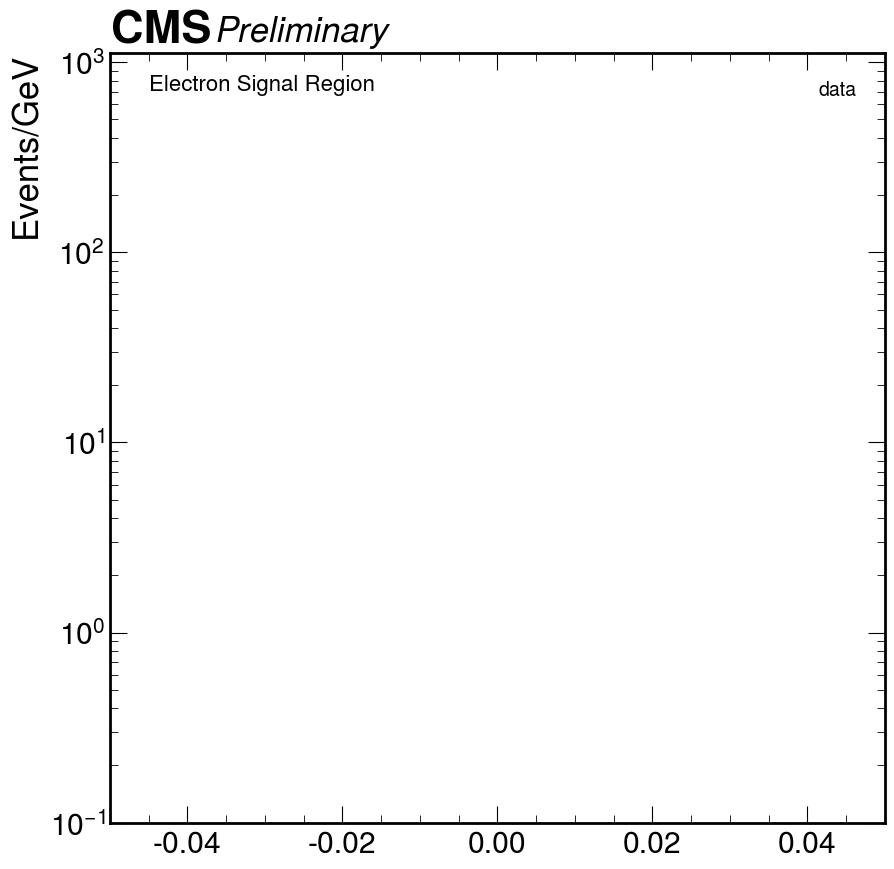

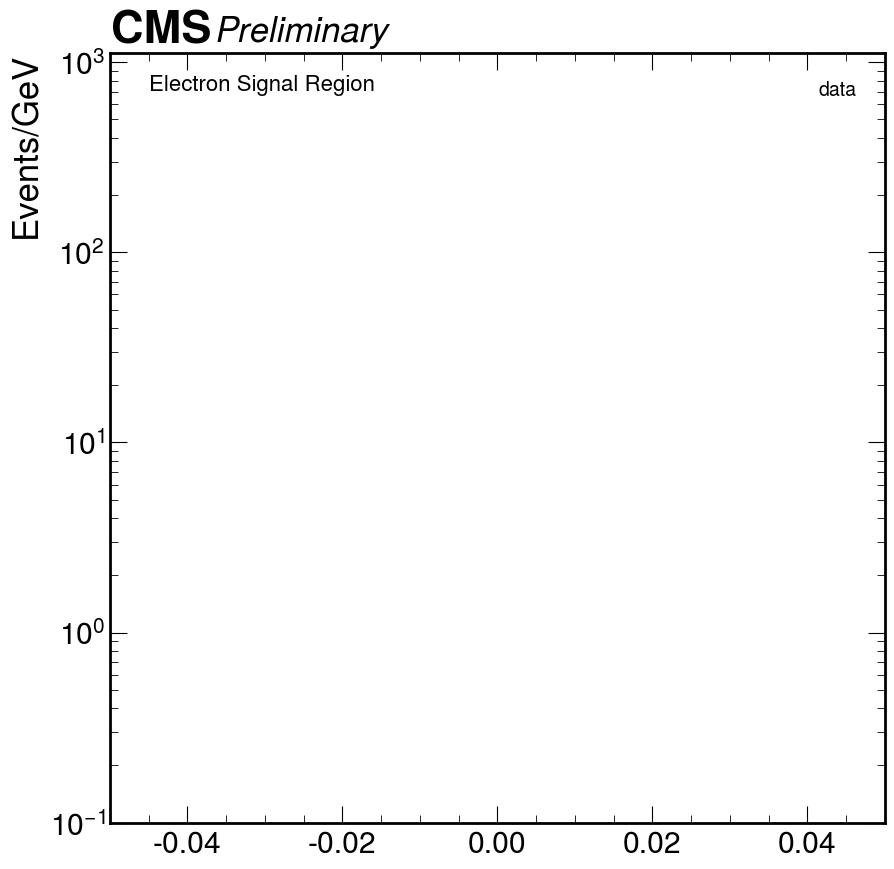

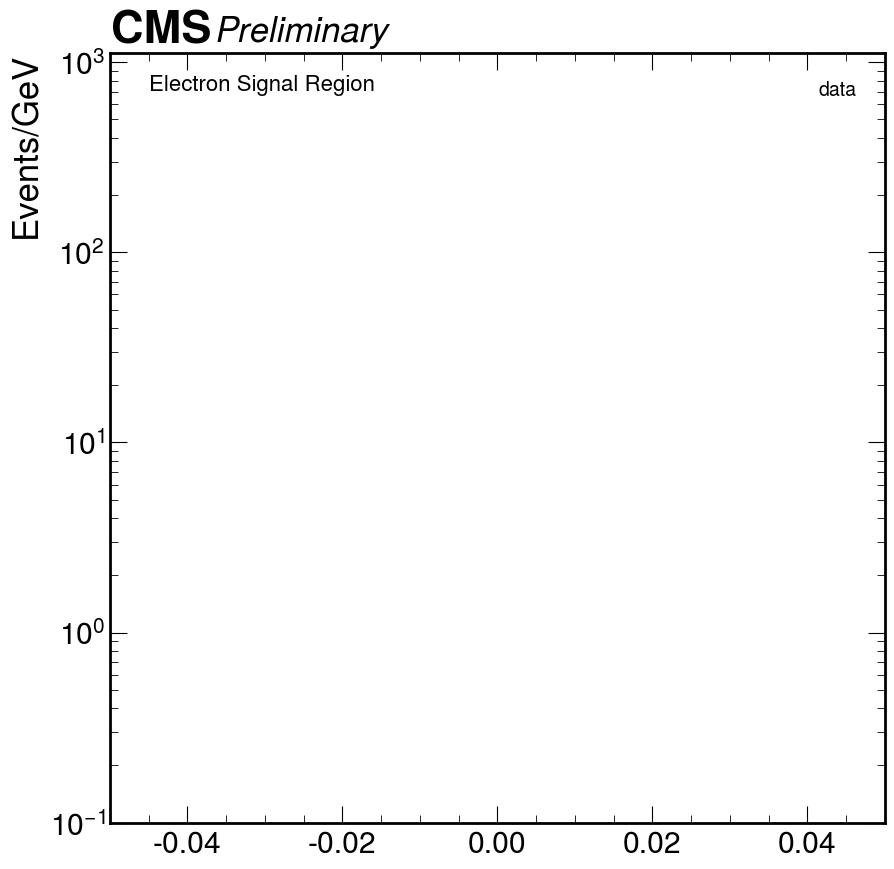

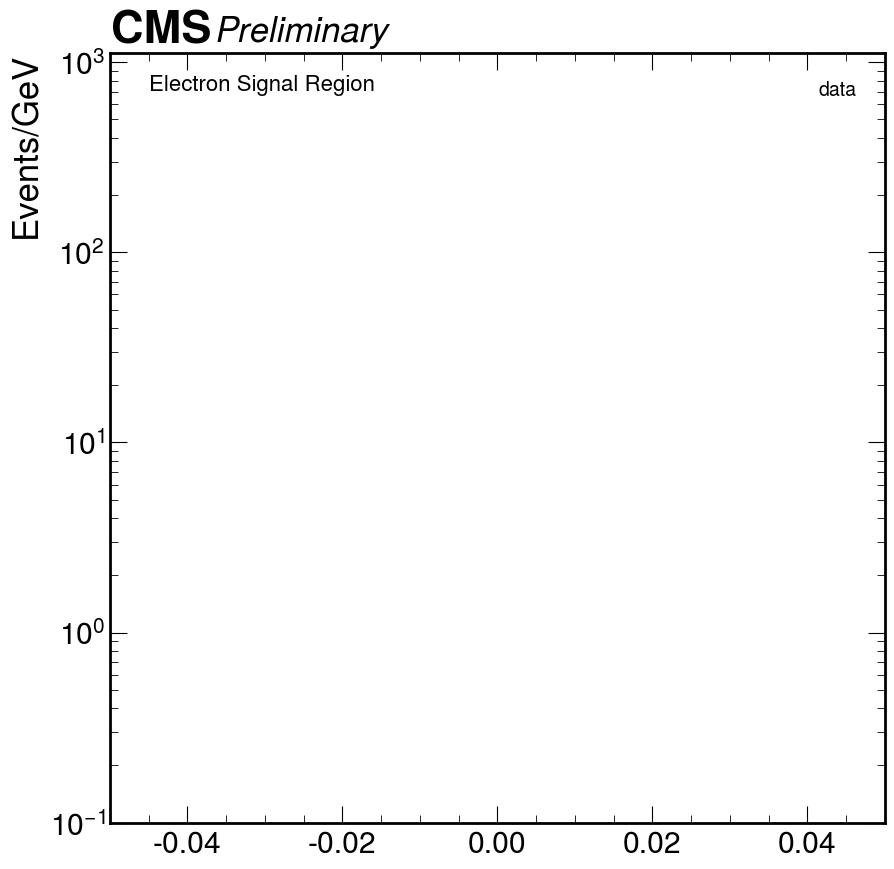

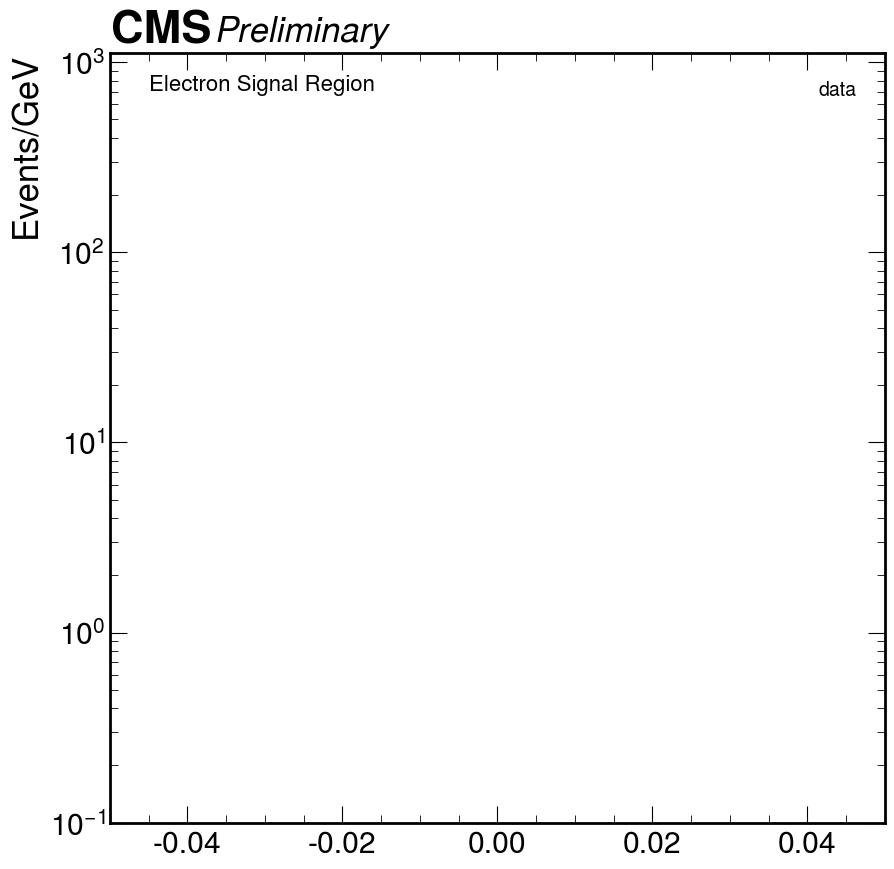

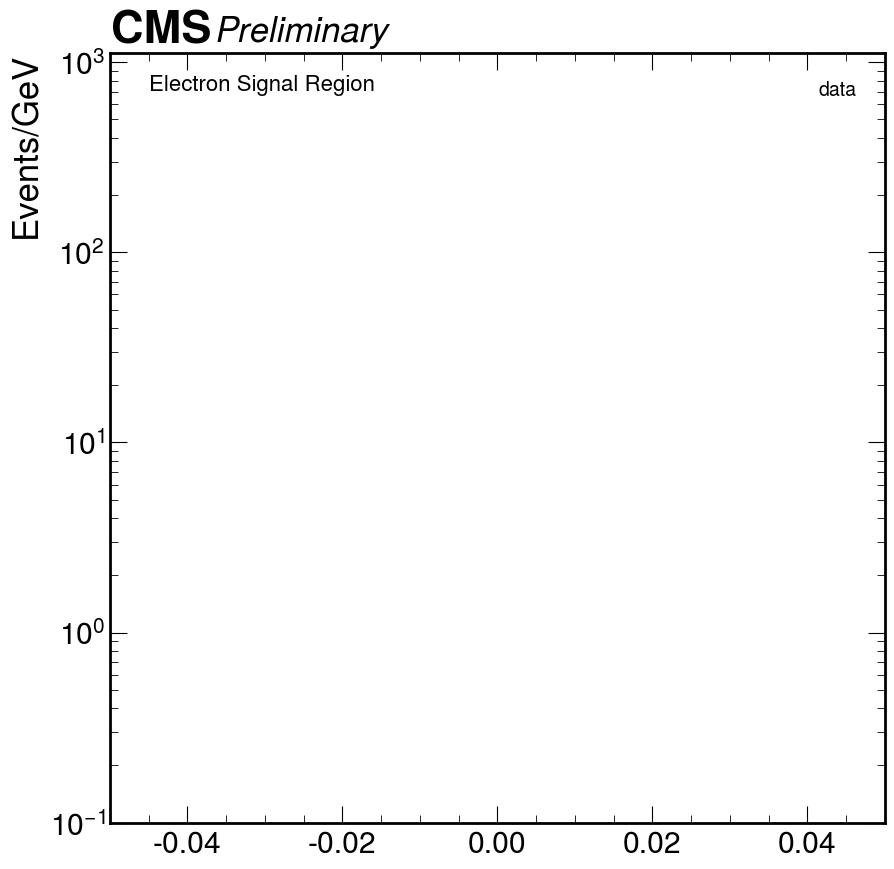

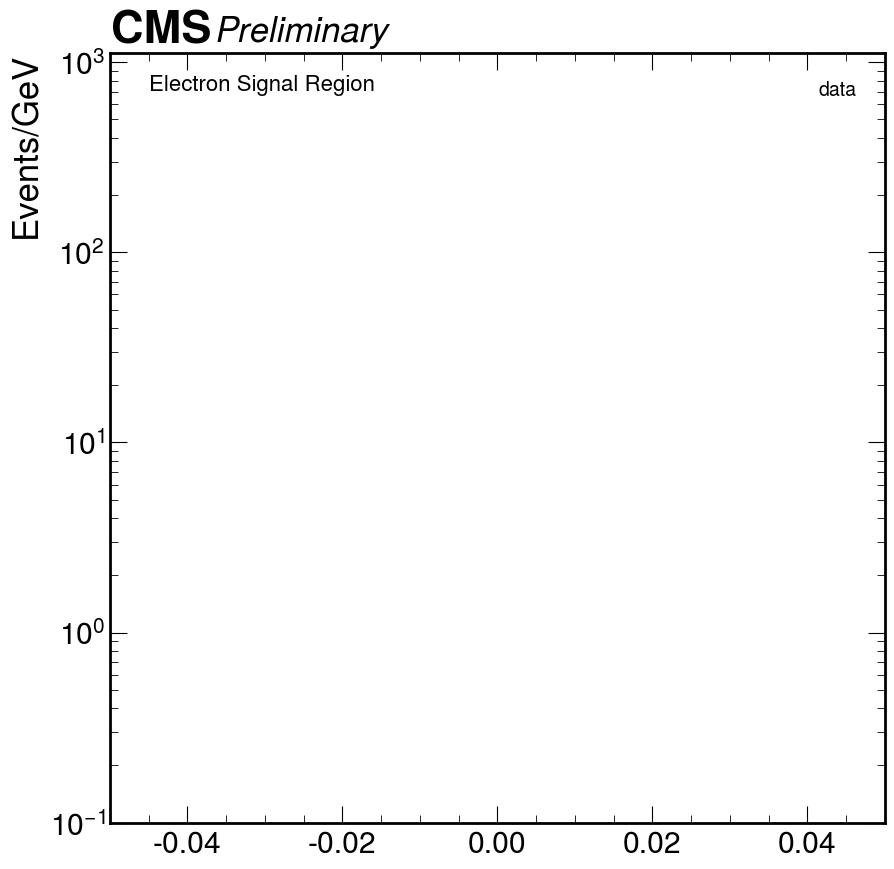

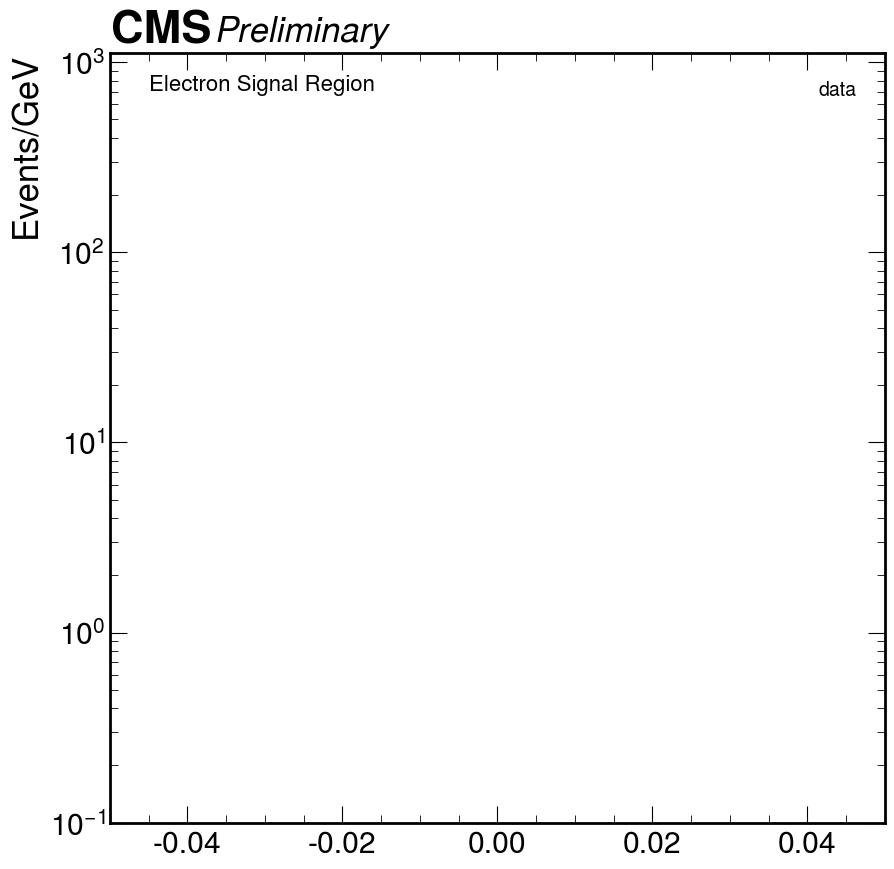

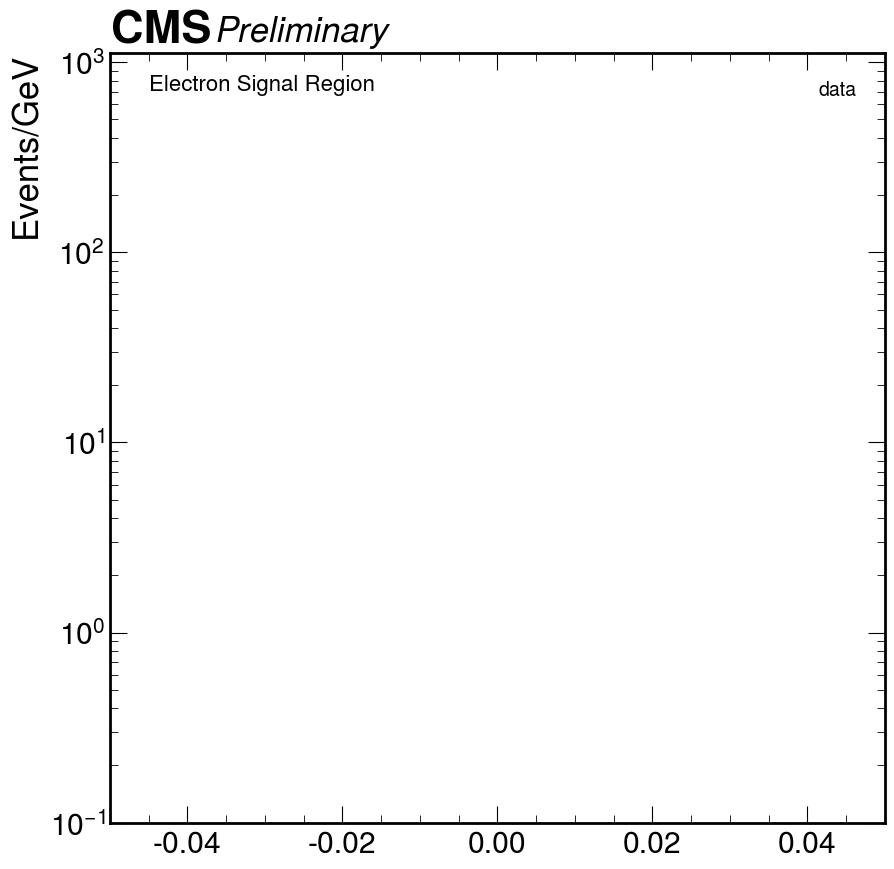

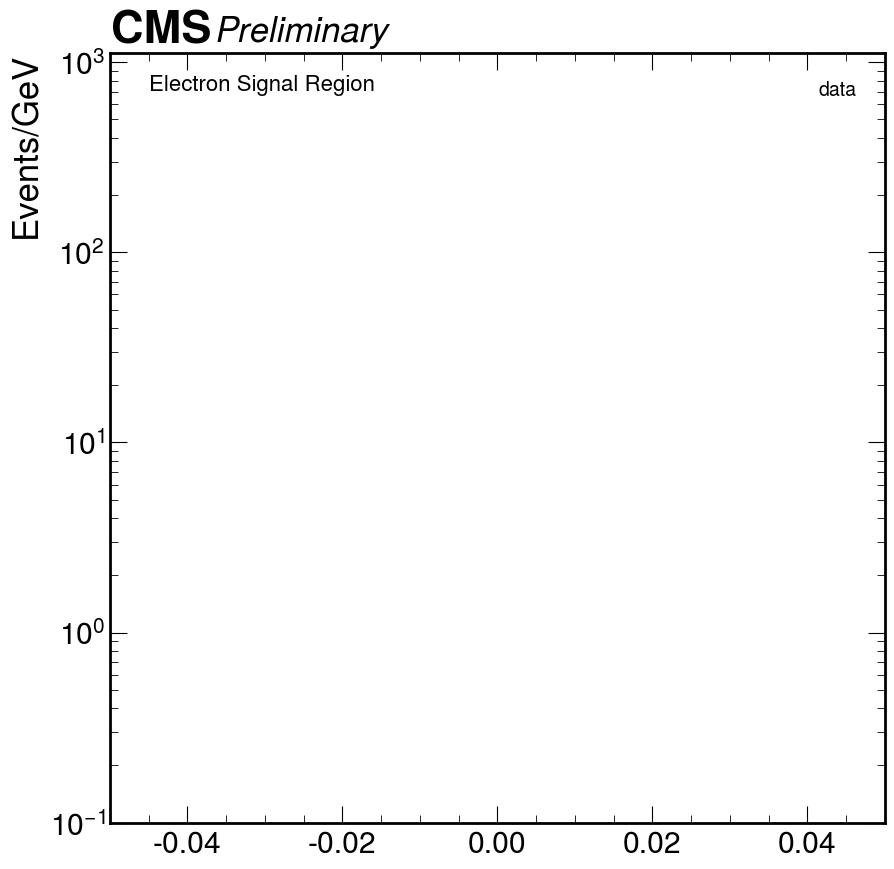

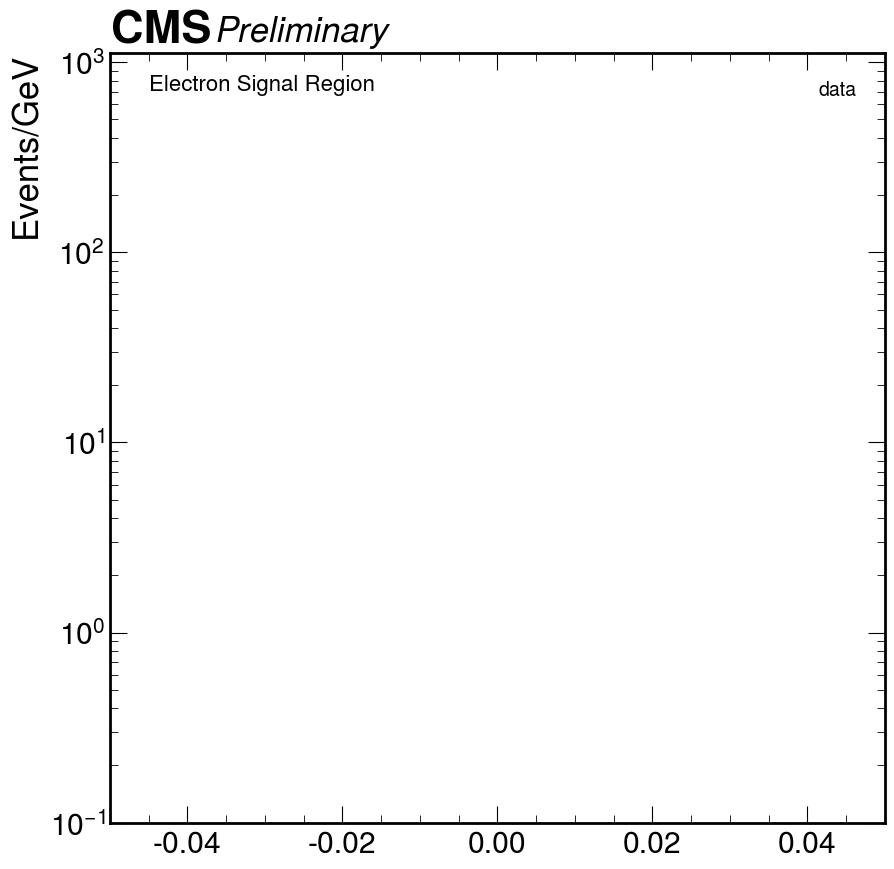

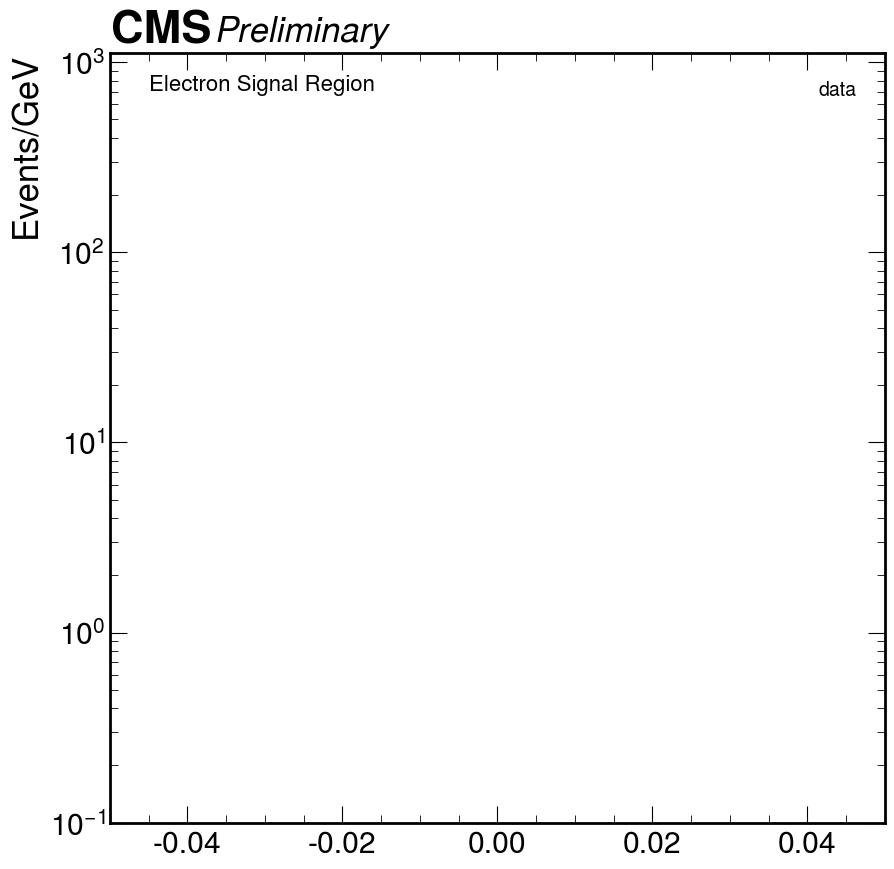

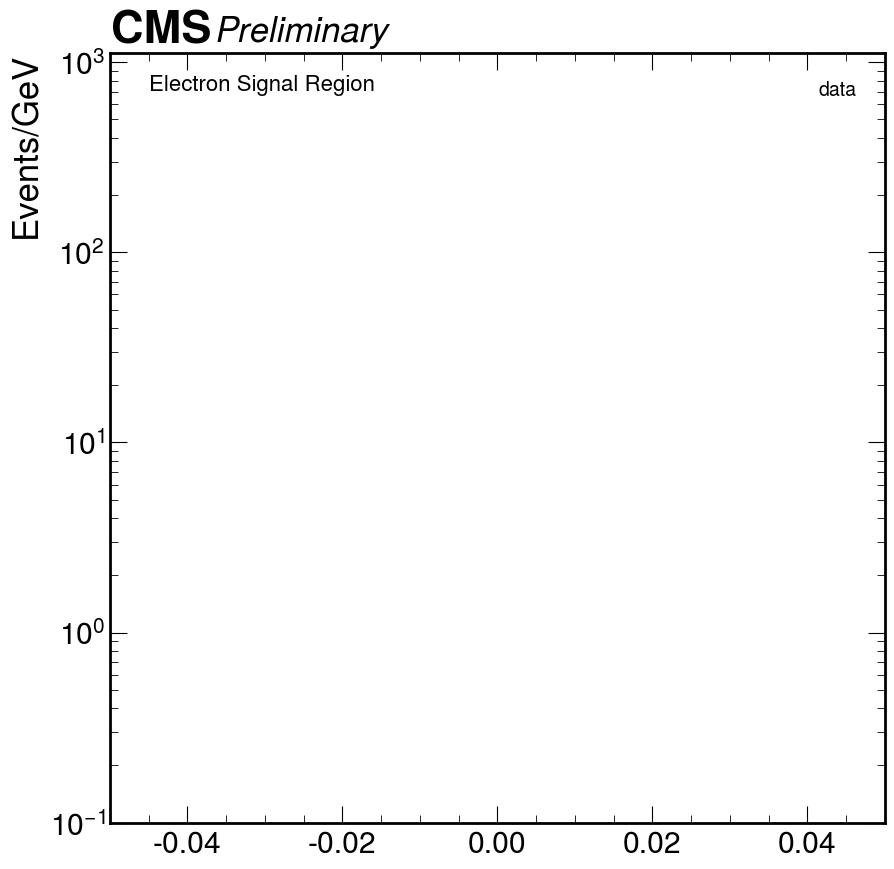

In [24]:
plot('2016preVFP', 'data', overlay=True)

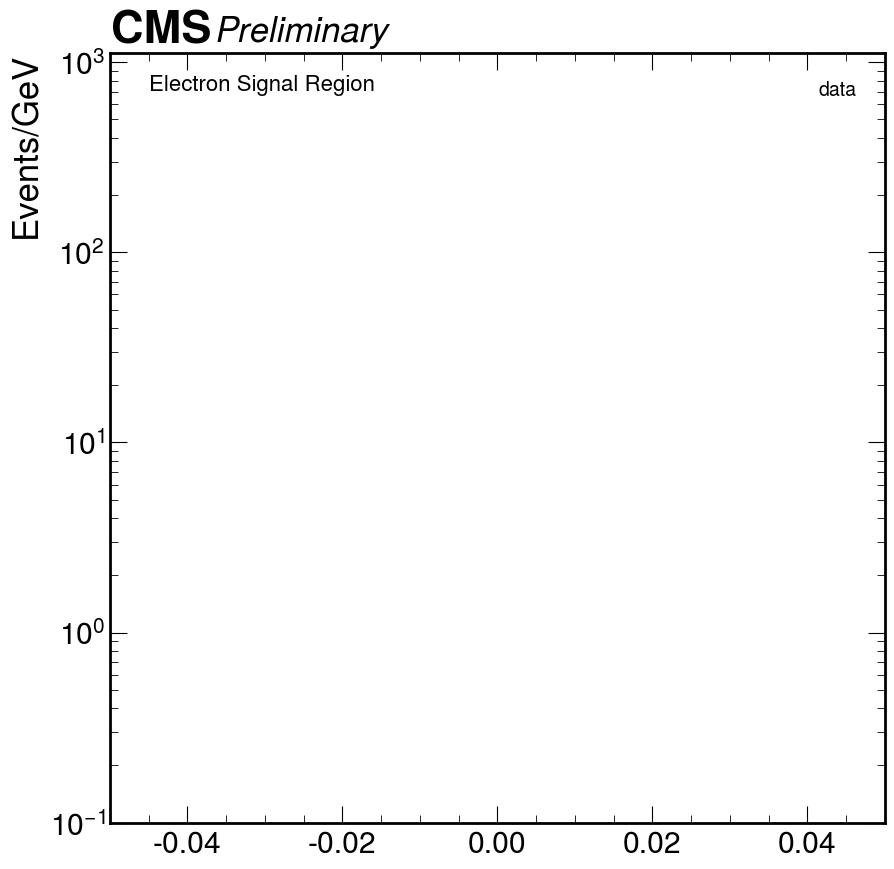

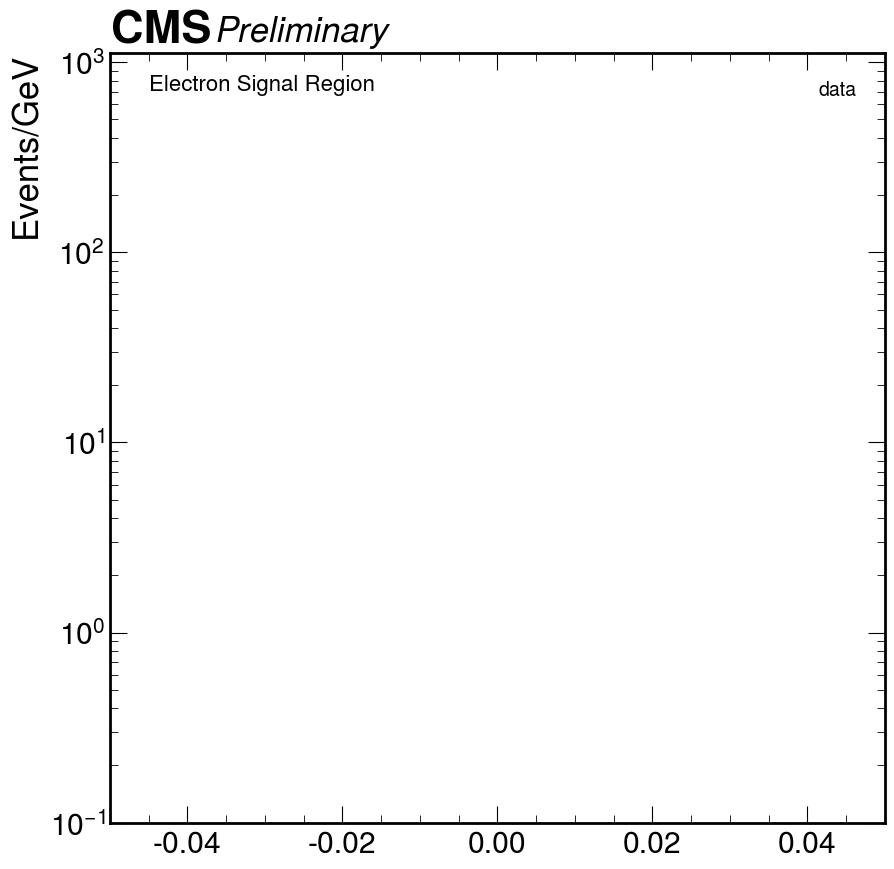

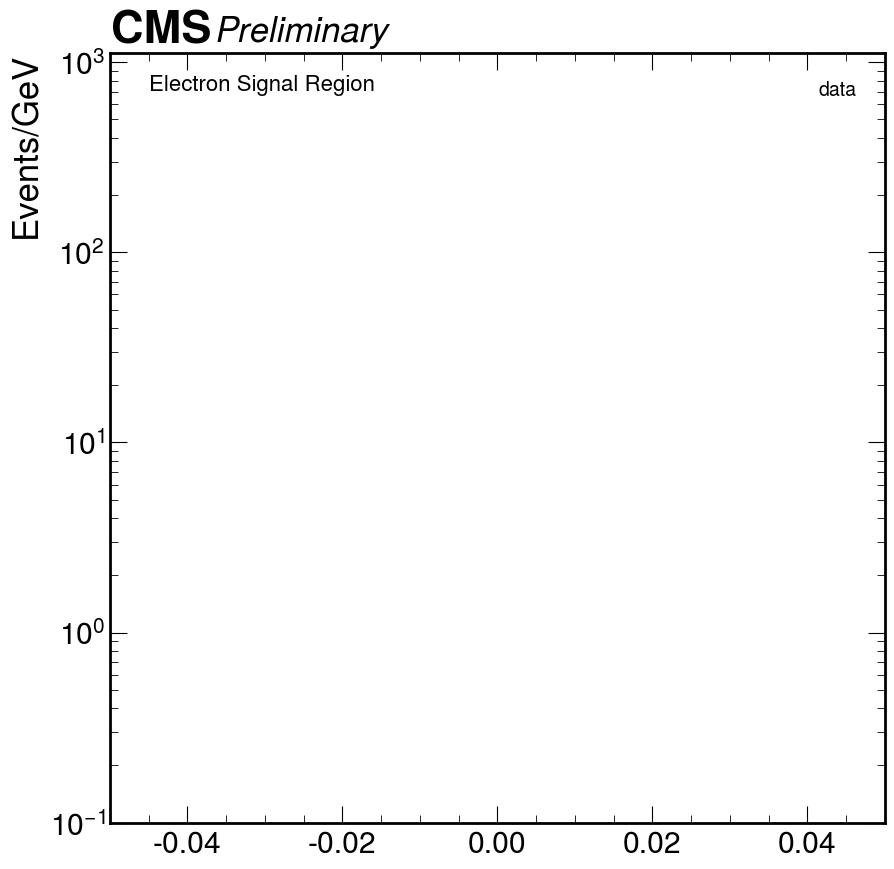

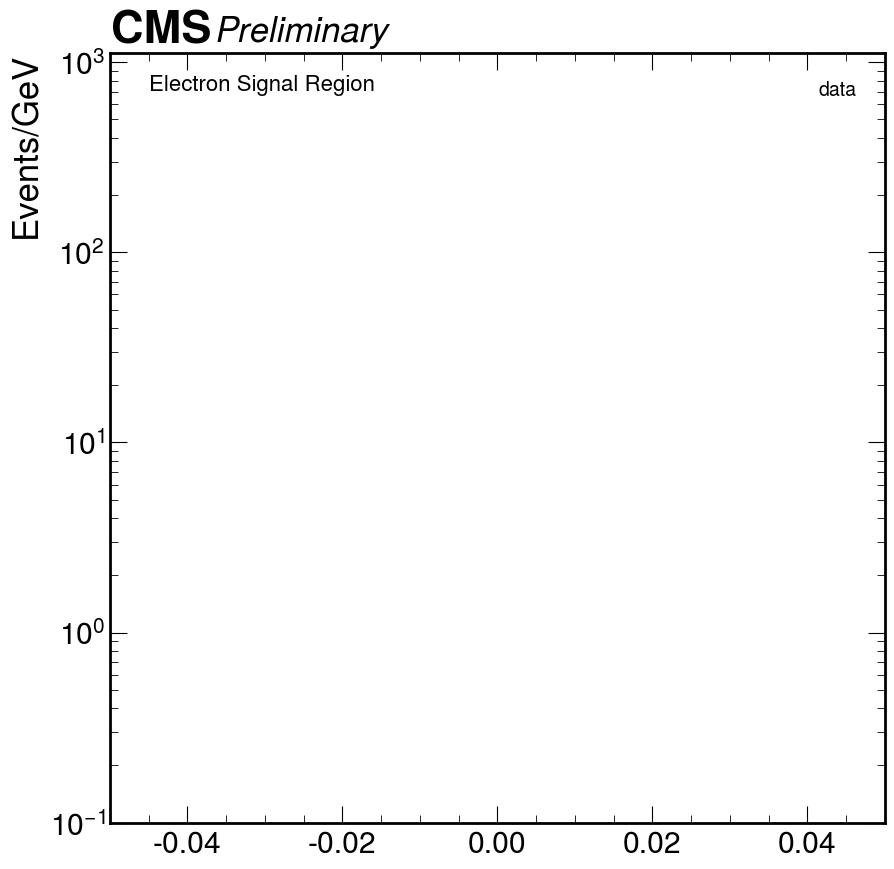

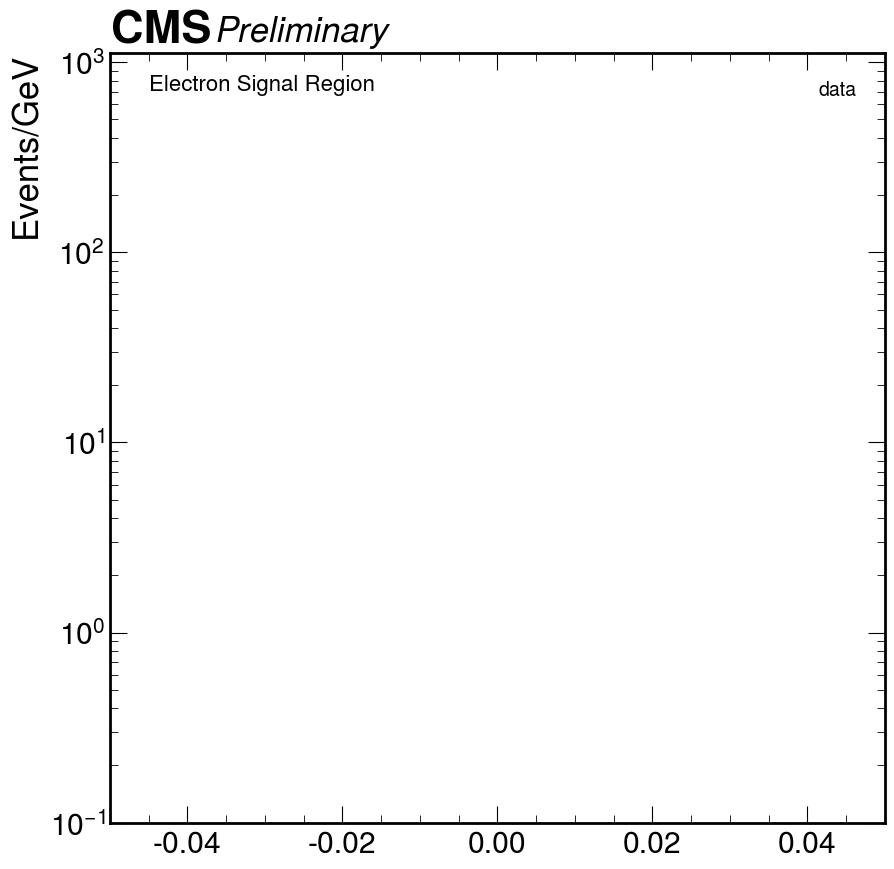

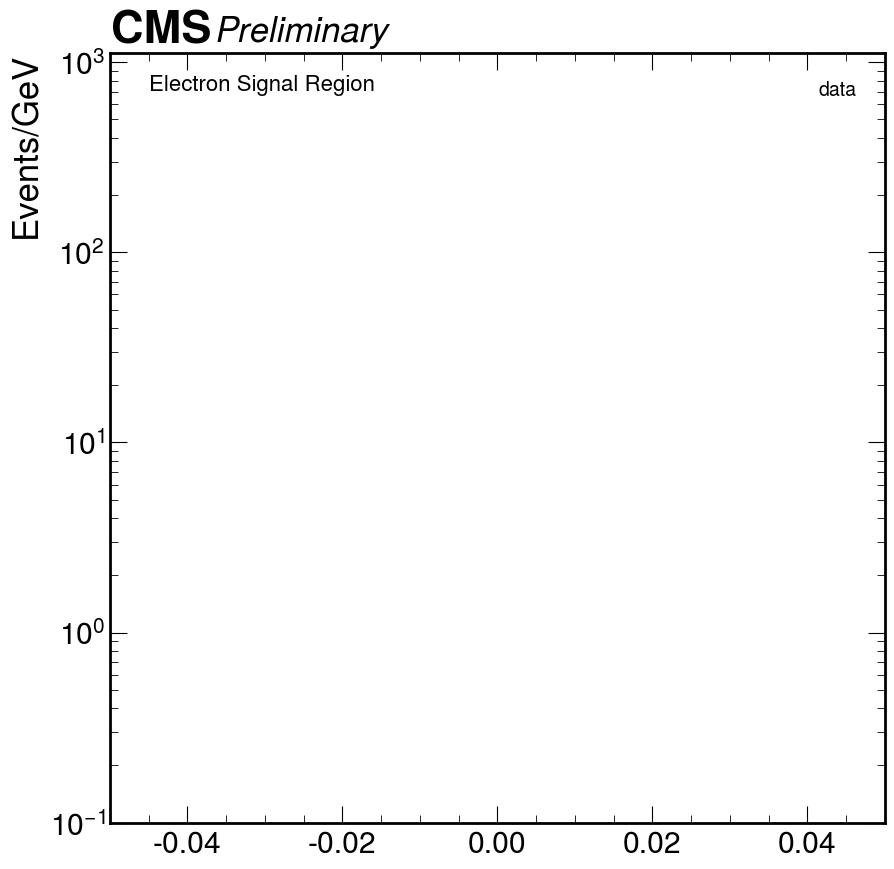

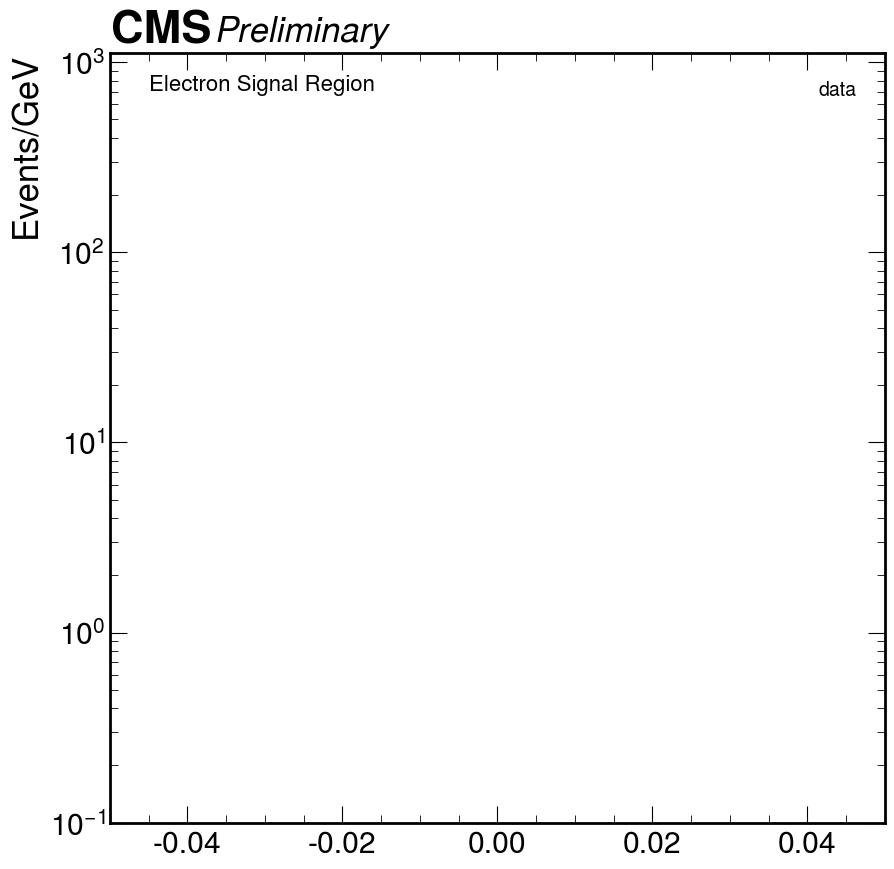

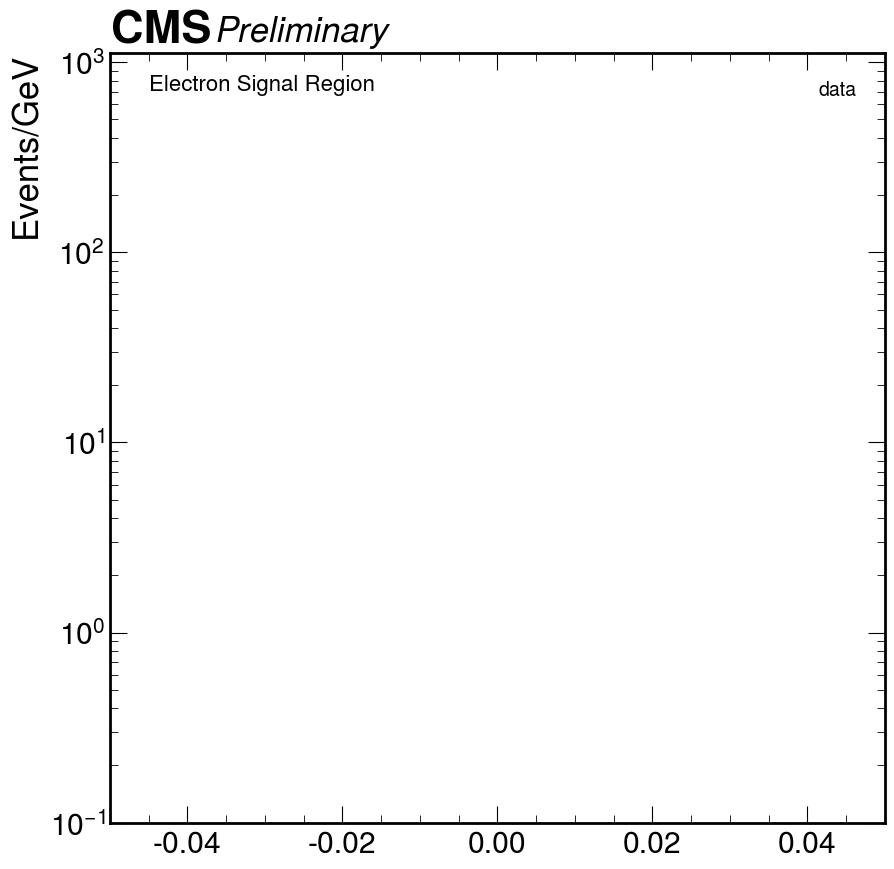

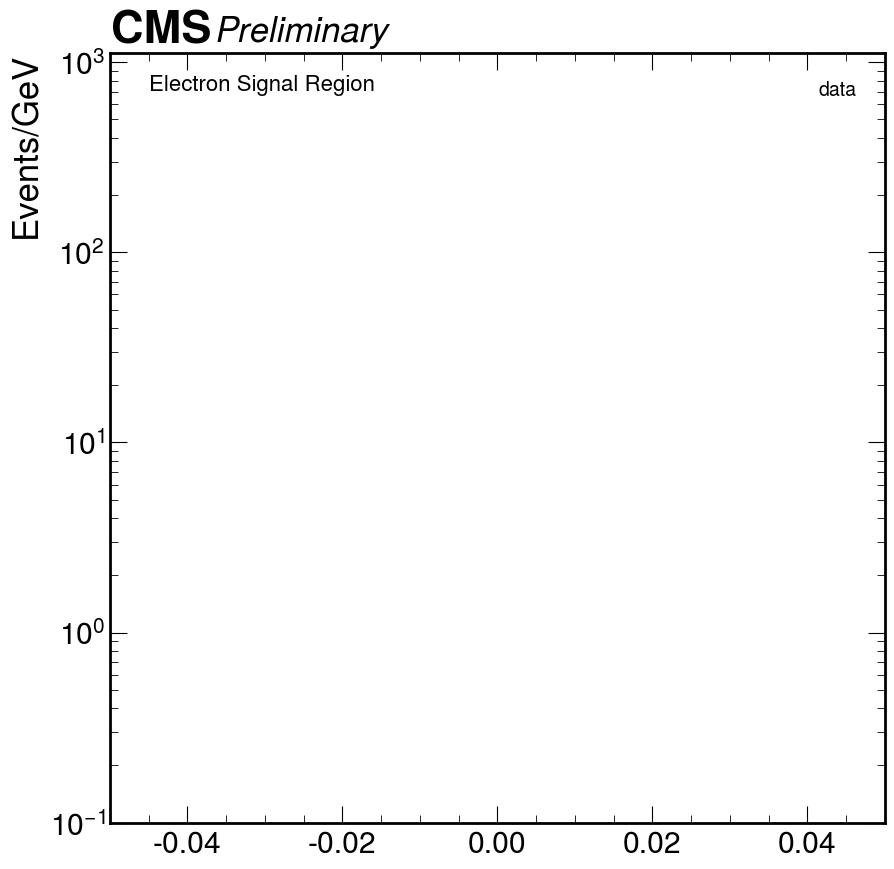

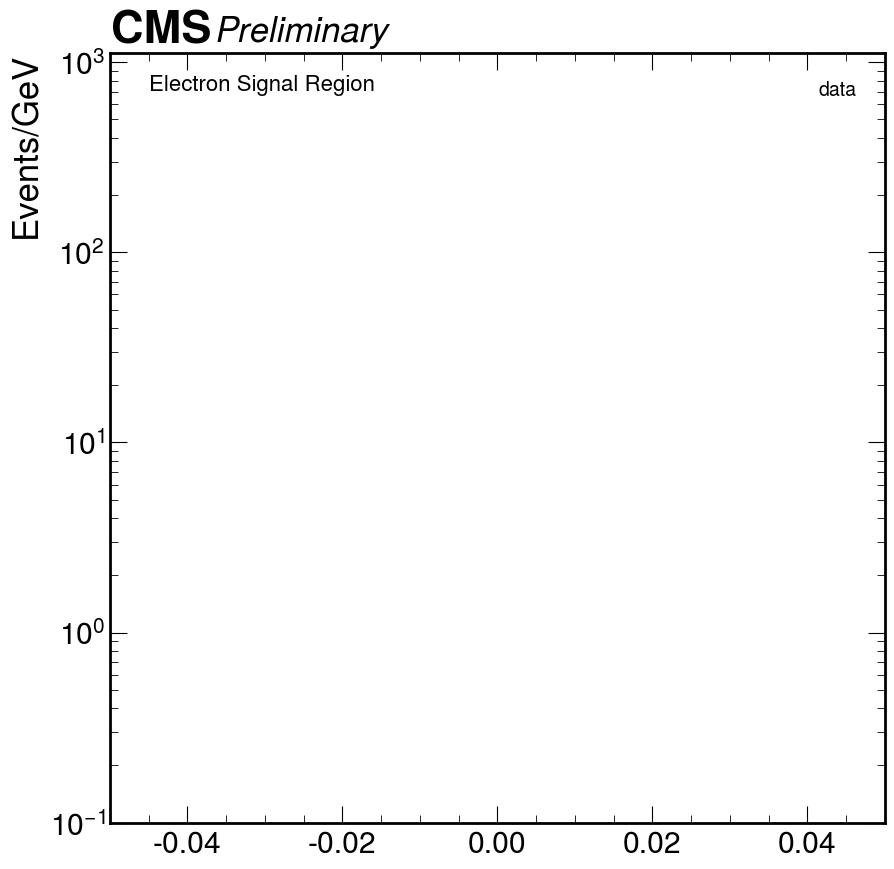

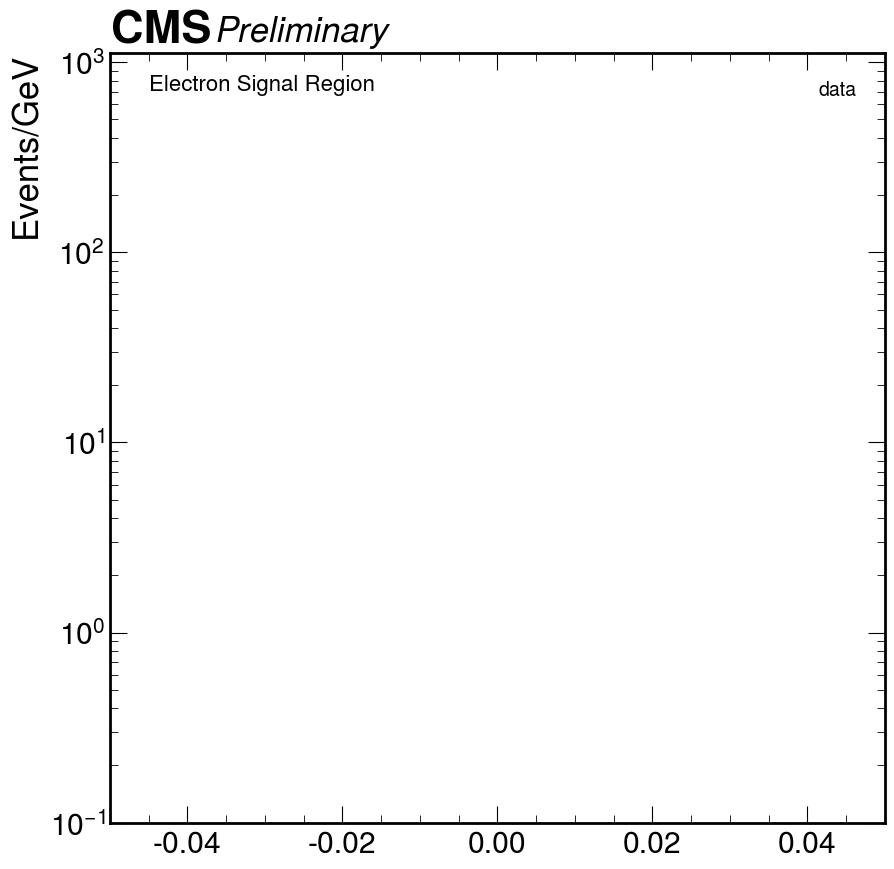

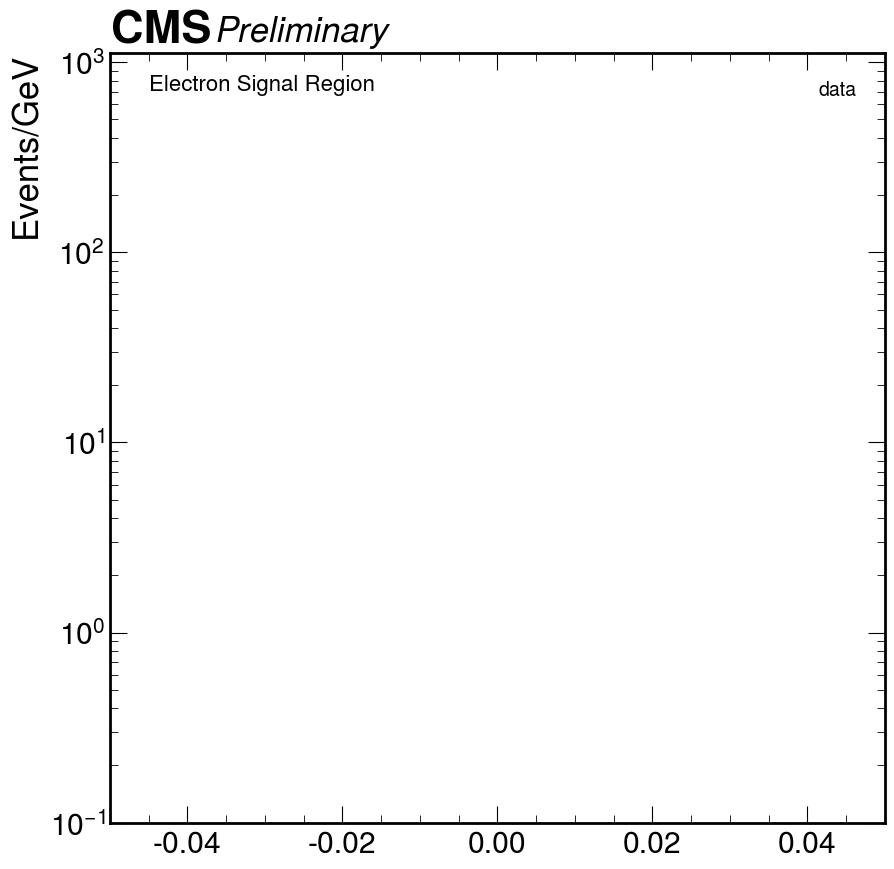

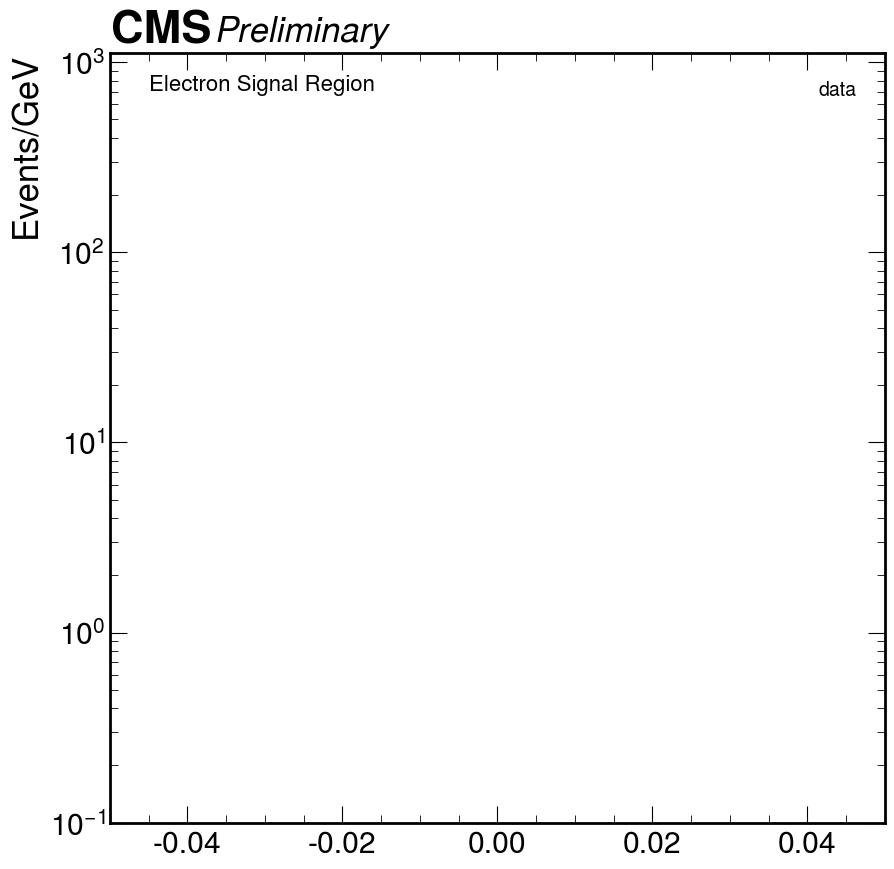

In [25]:
plot('2016postVFP', 'data', overlay=True)

Regions: esr


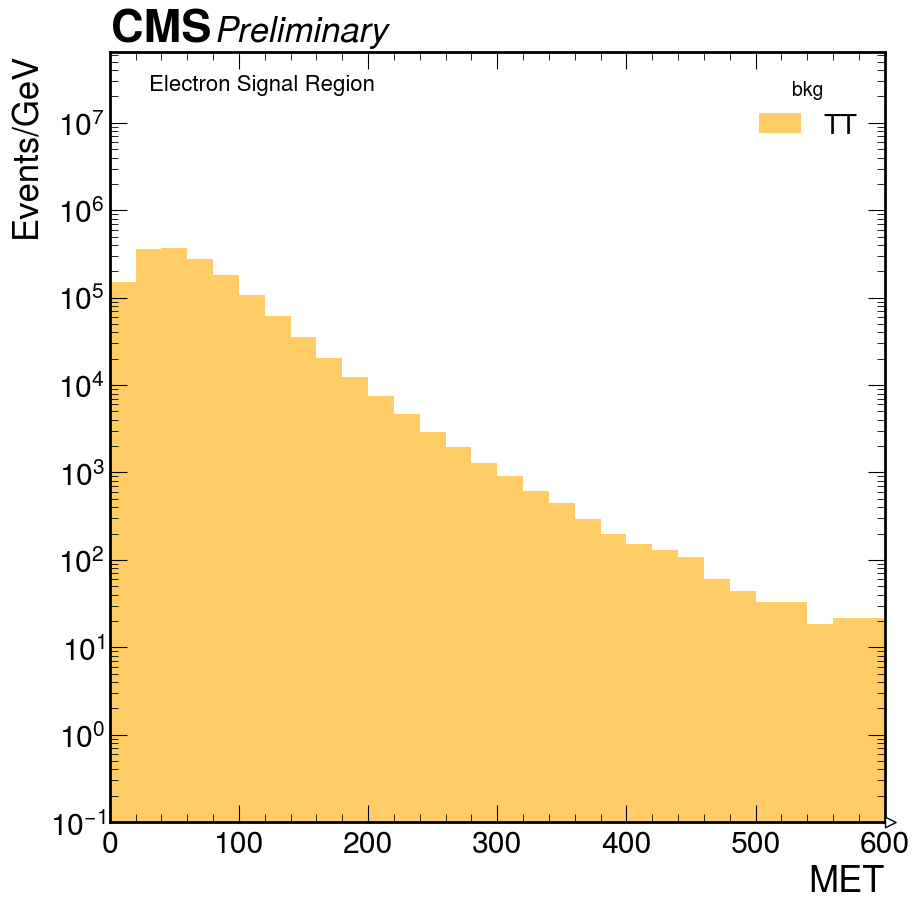

Regions: msr


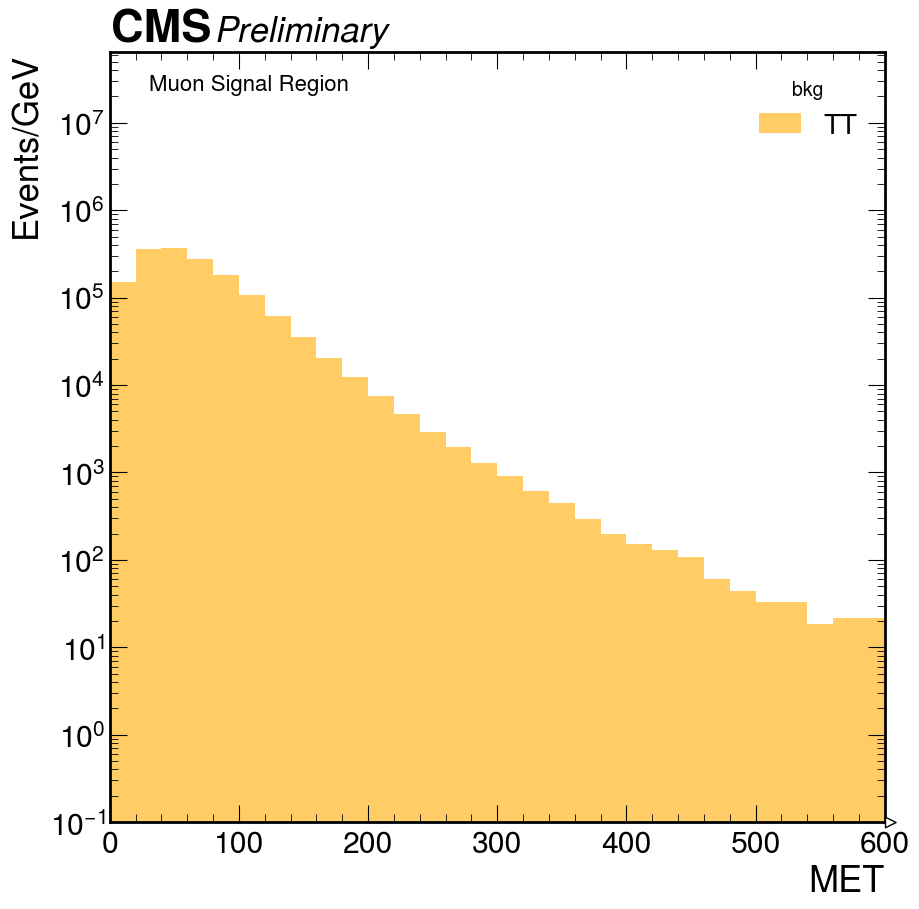

Regions: esr


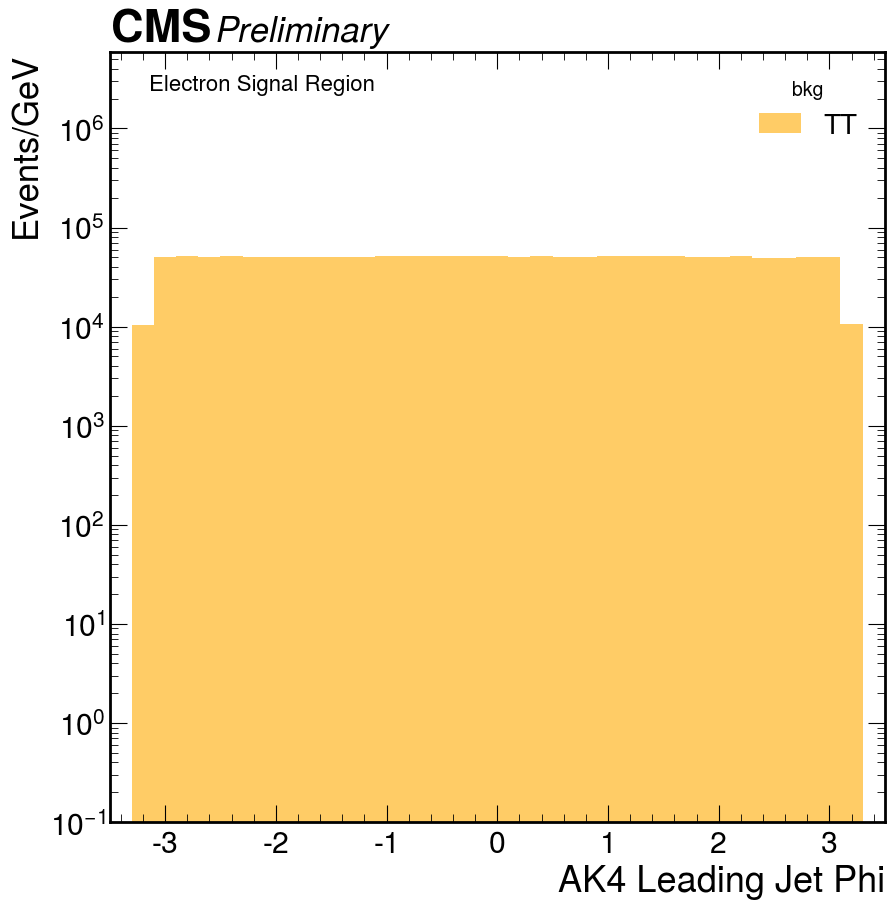

Regions: msr


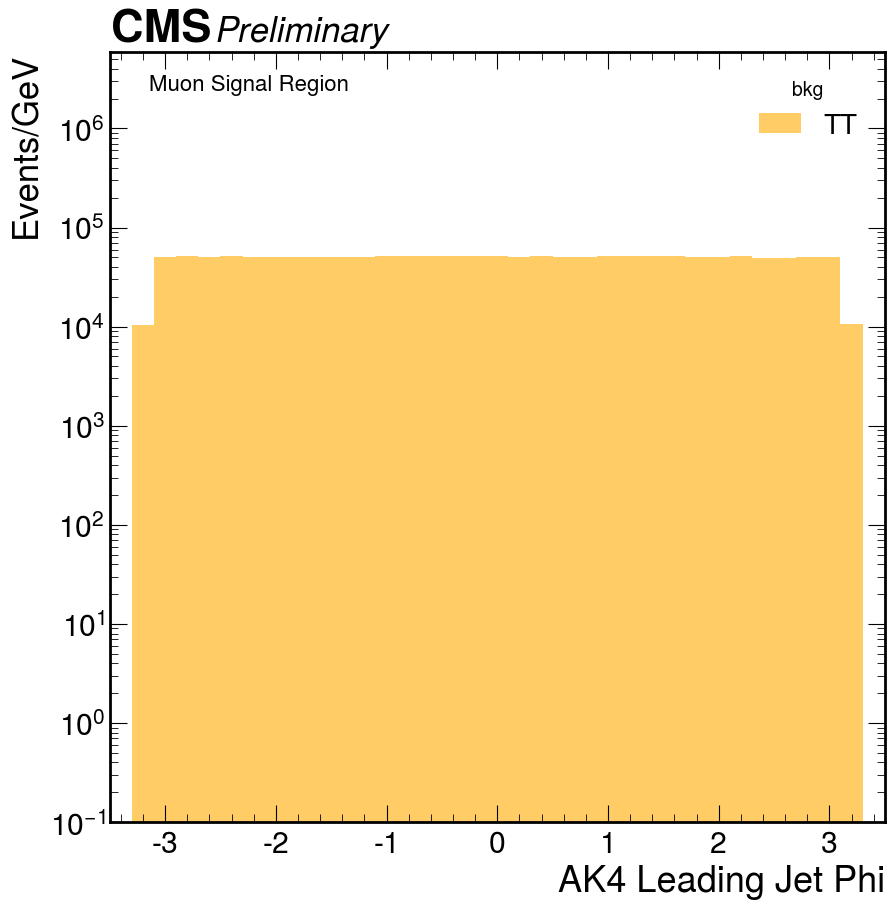

Regions: esr


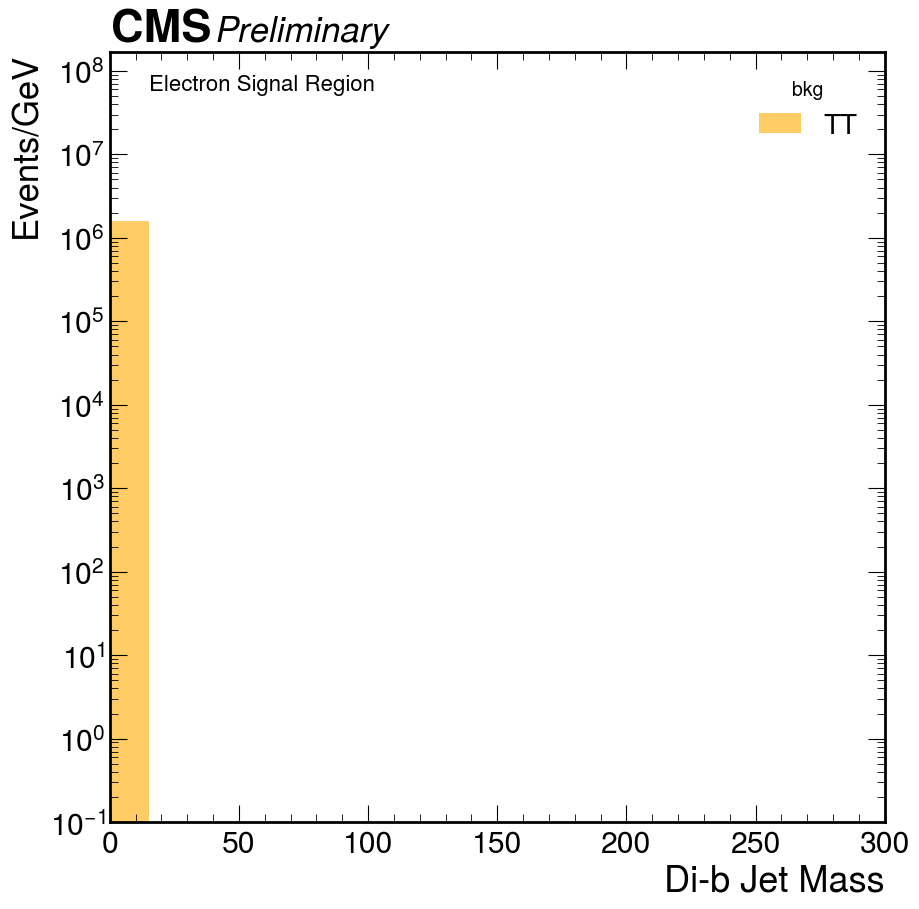

Regions: msr


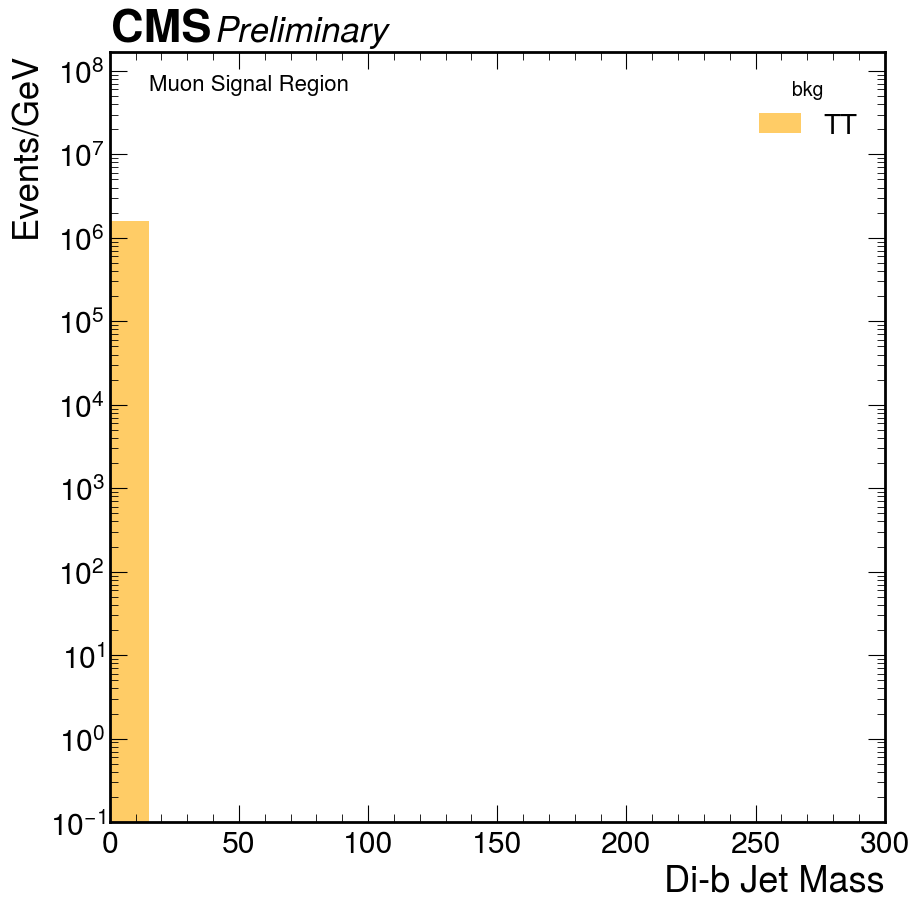

Regions: esr


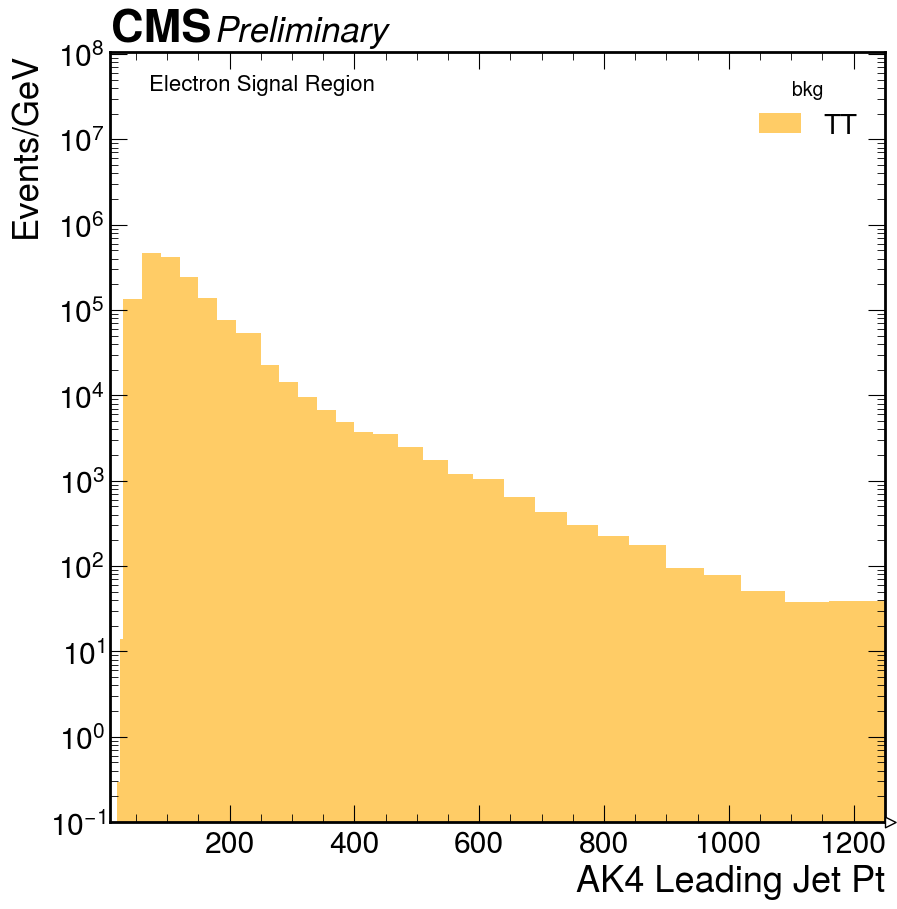

Regions: msr


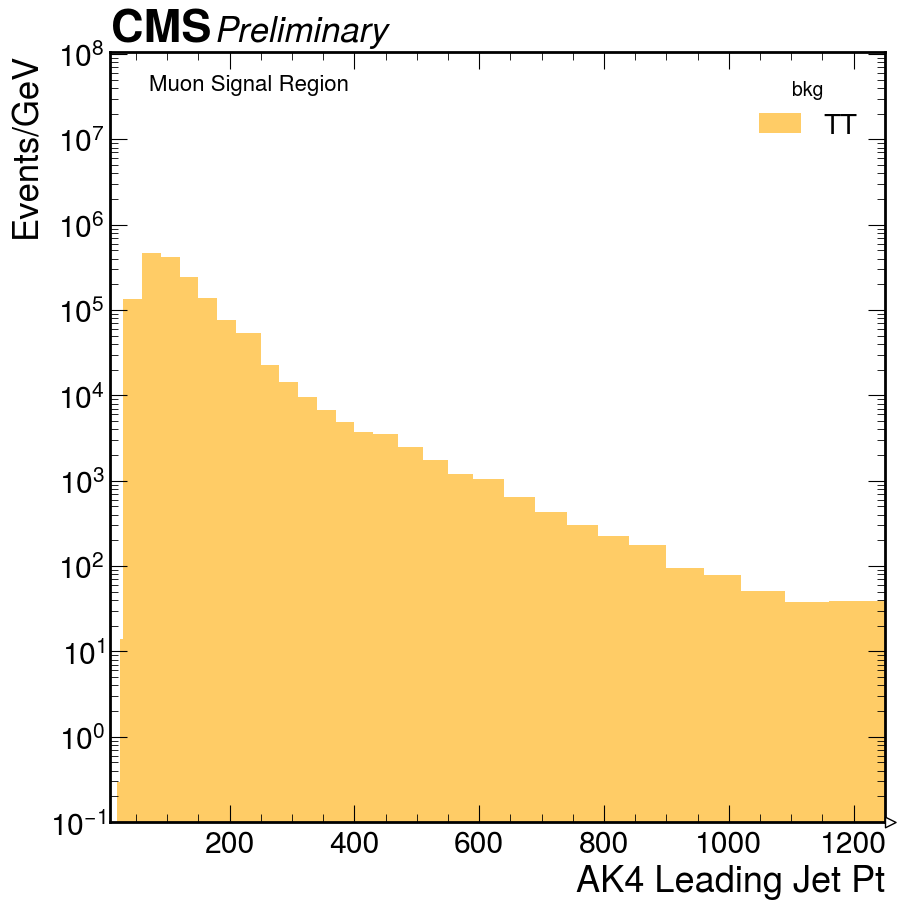

Regions: esr


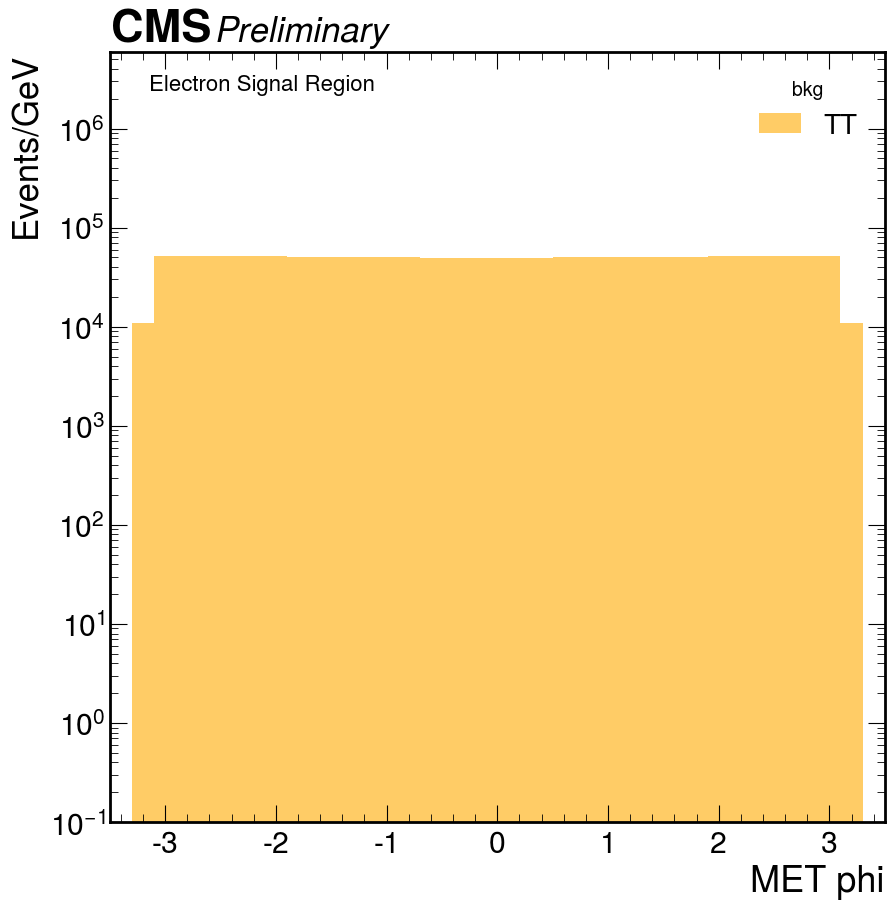

Regions: msr


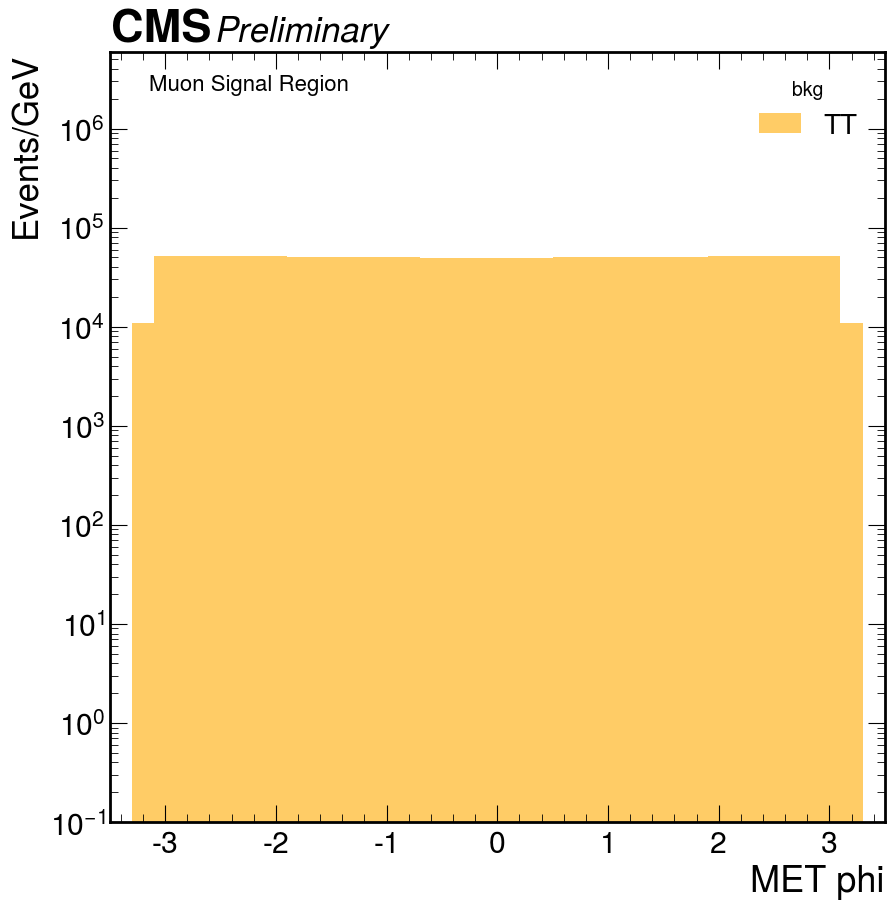

Regions: esr


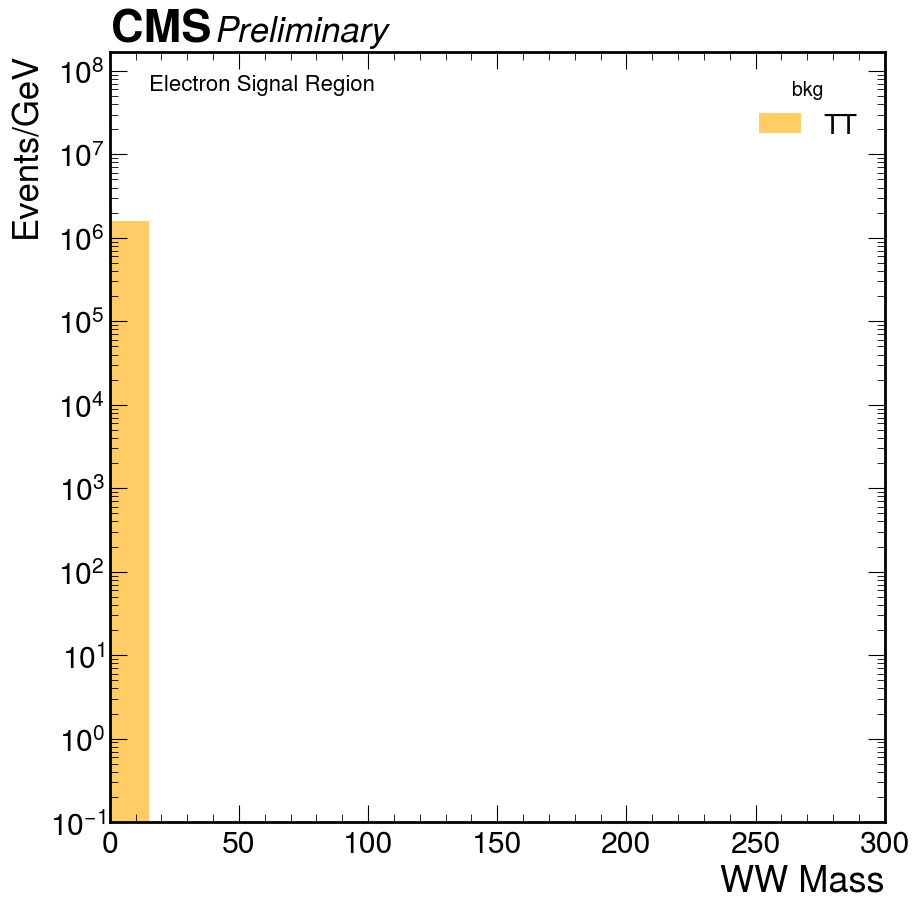

Regions: msr


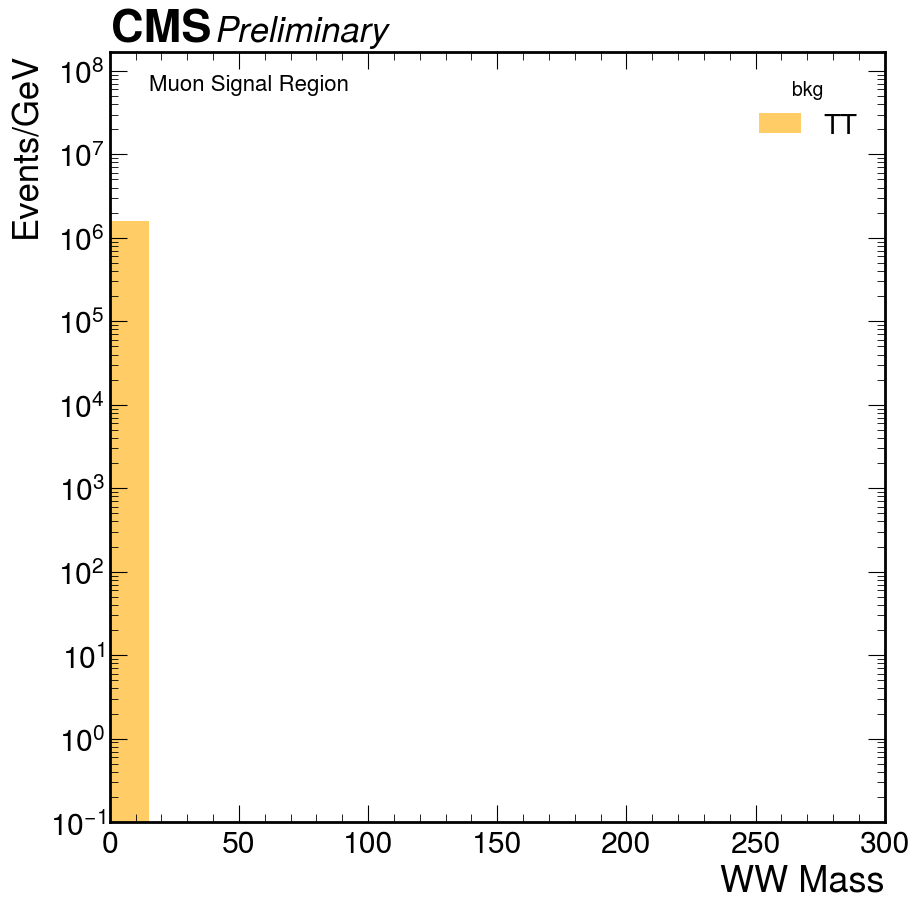

Regions: esr


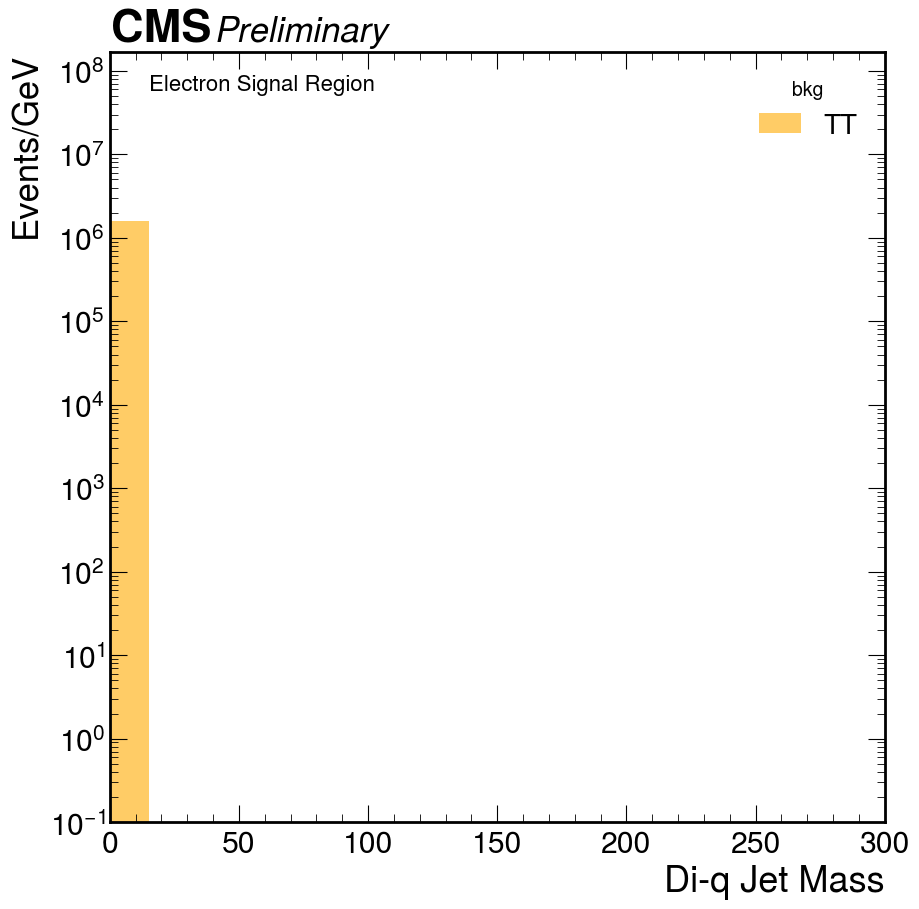

Regions: msr


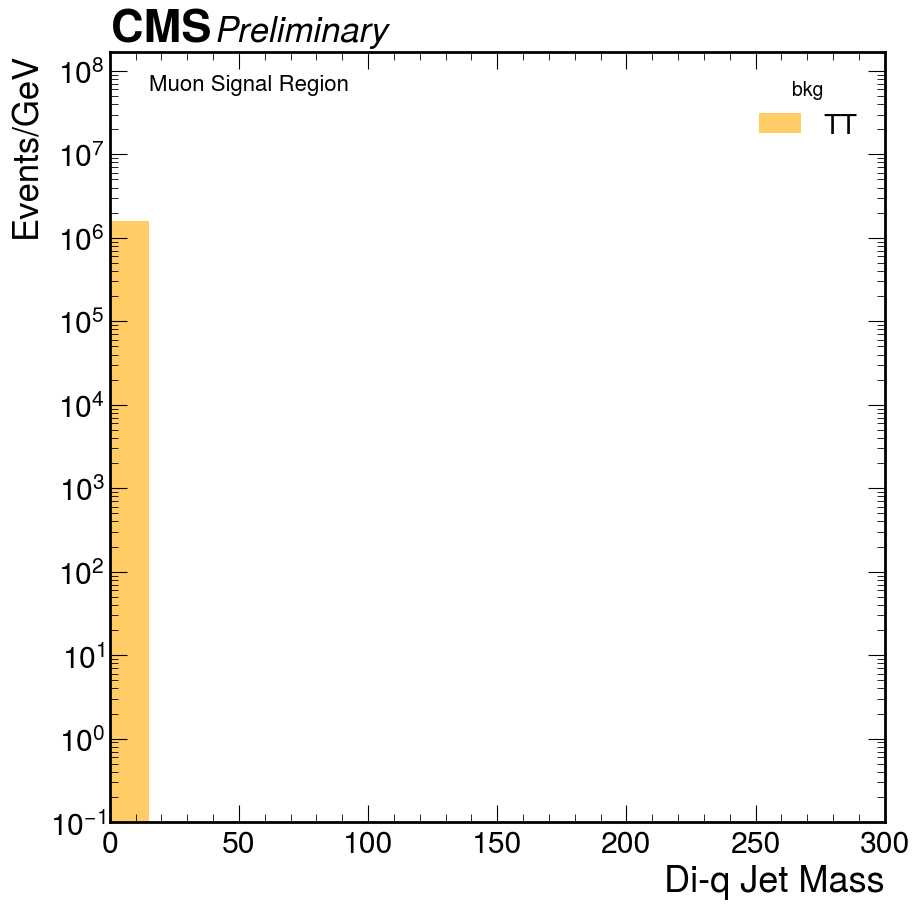

Regions: esr


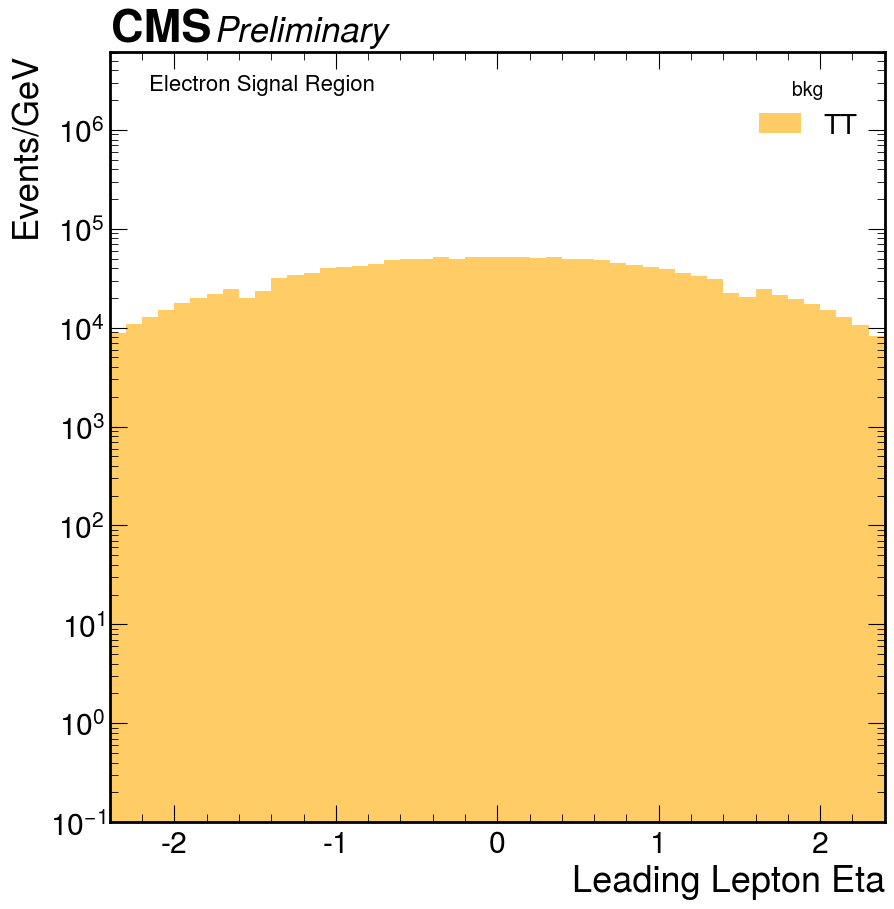

Regions: msr


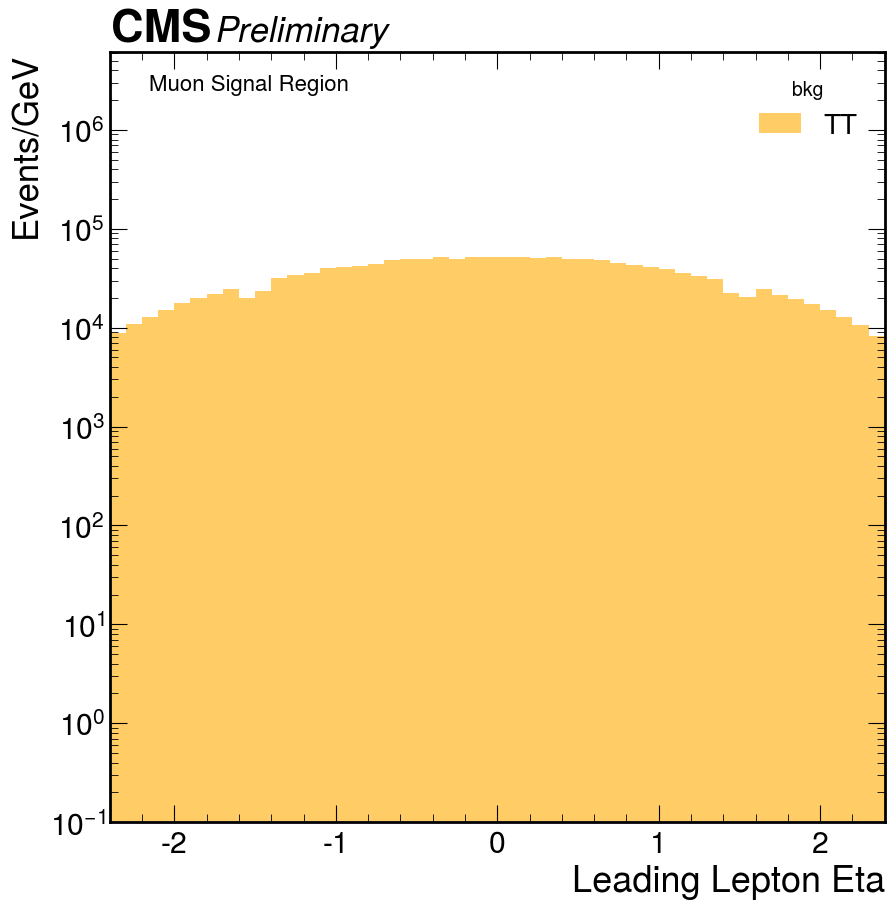

Regions: esr


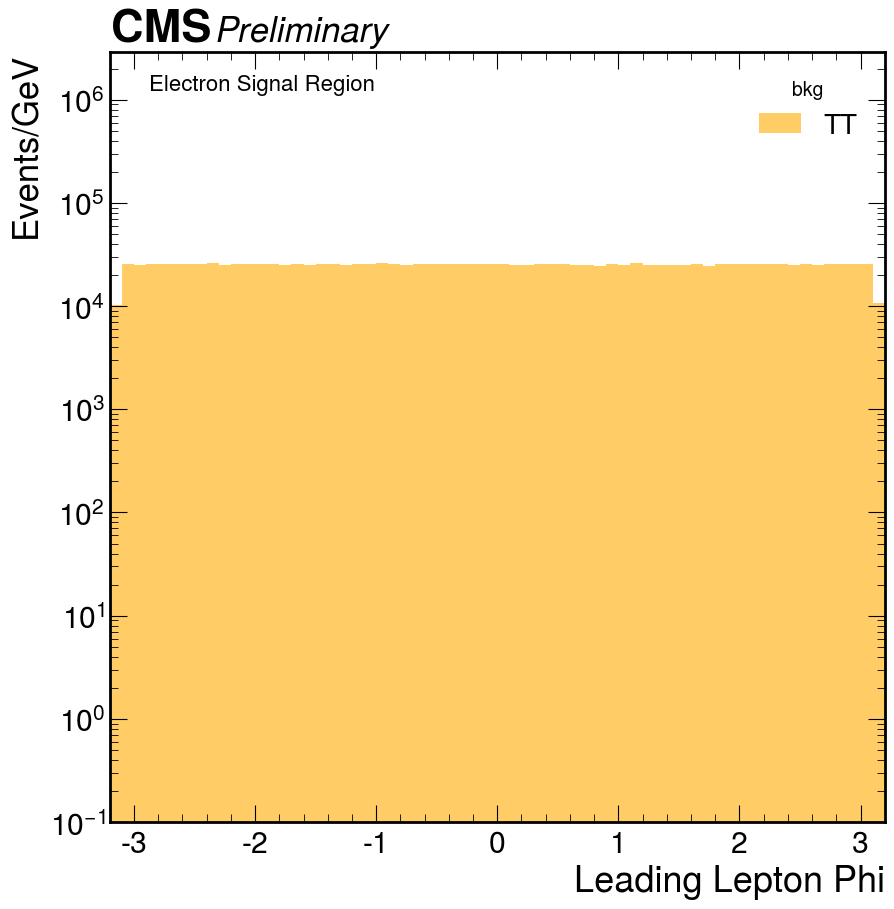

Regions: msr


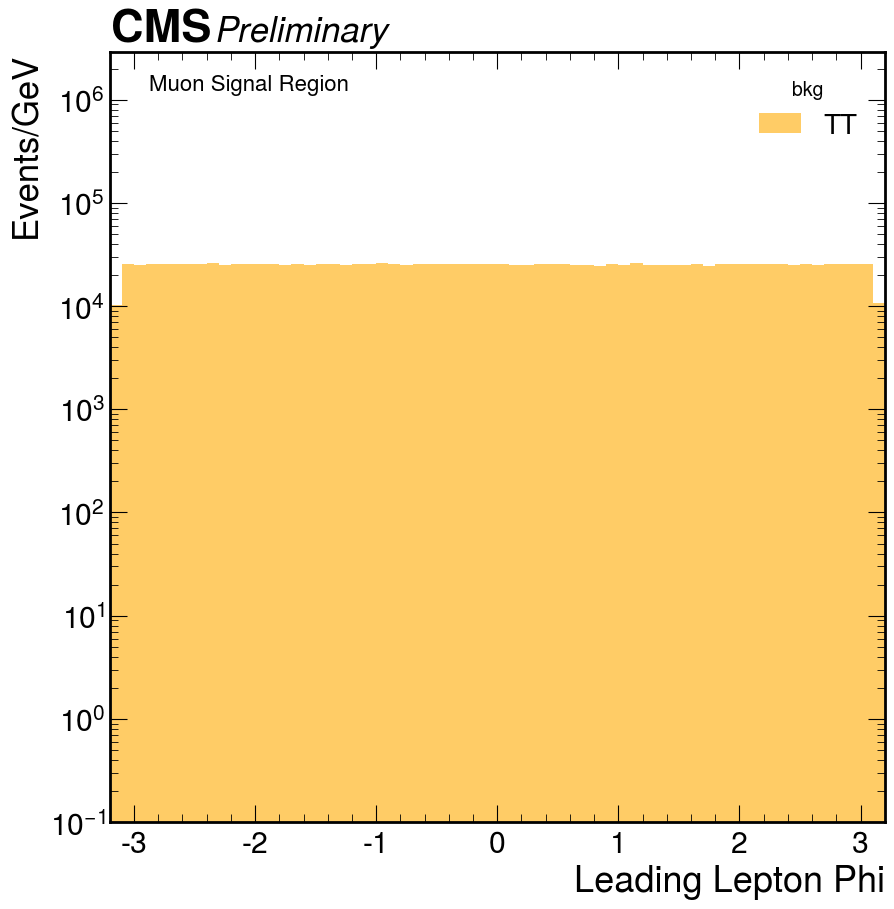

Regions: esr


/var/folders/hj/t7nt9g255973s5cwl4skm39m0000gn/T/ipykernel_1912/233384775.py:59: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


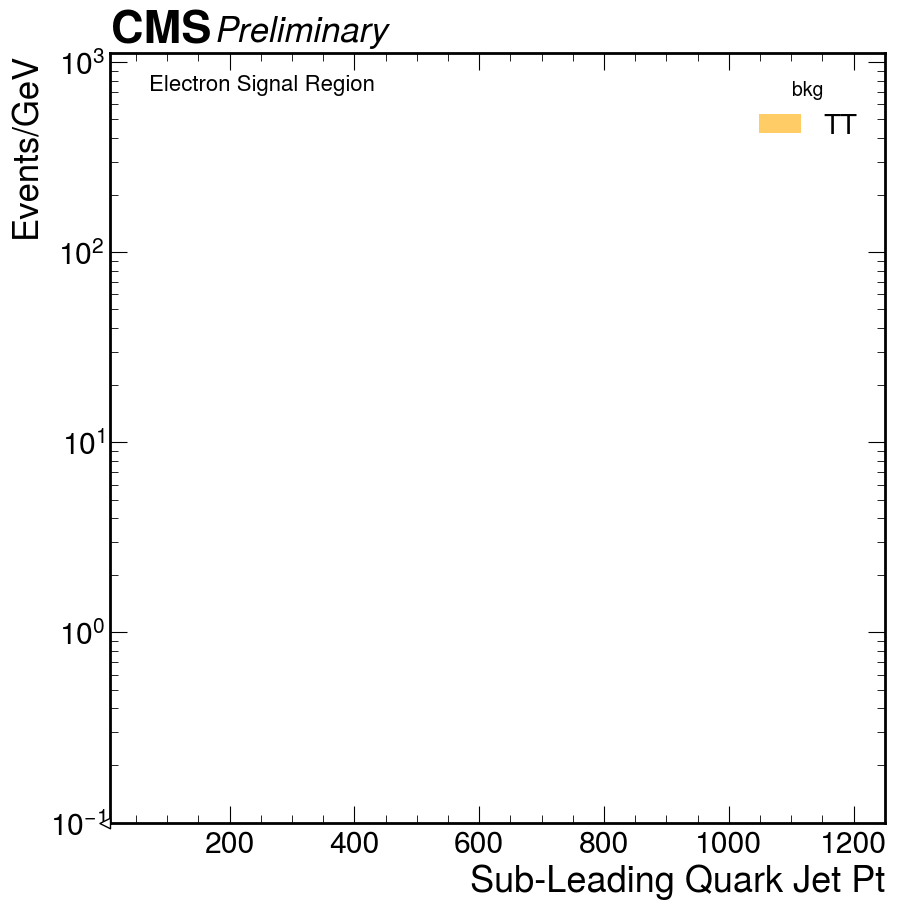

Regions: msr


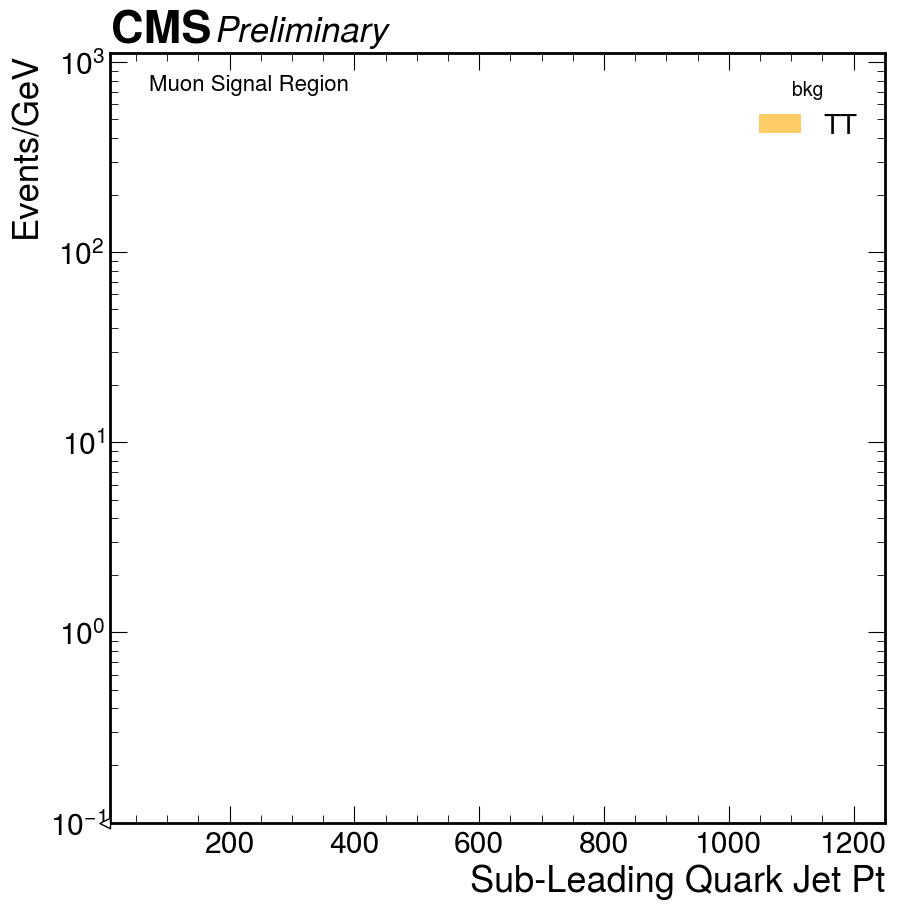

Regions: esr


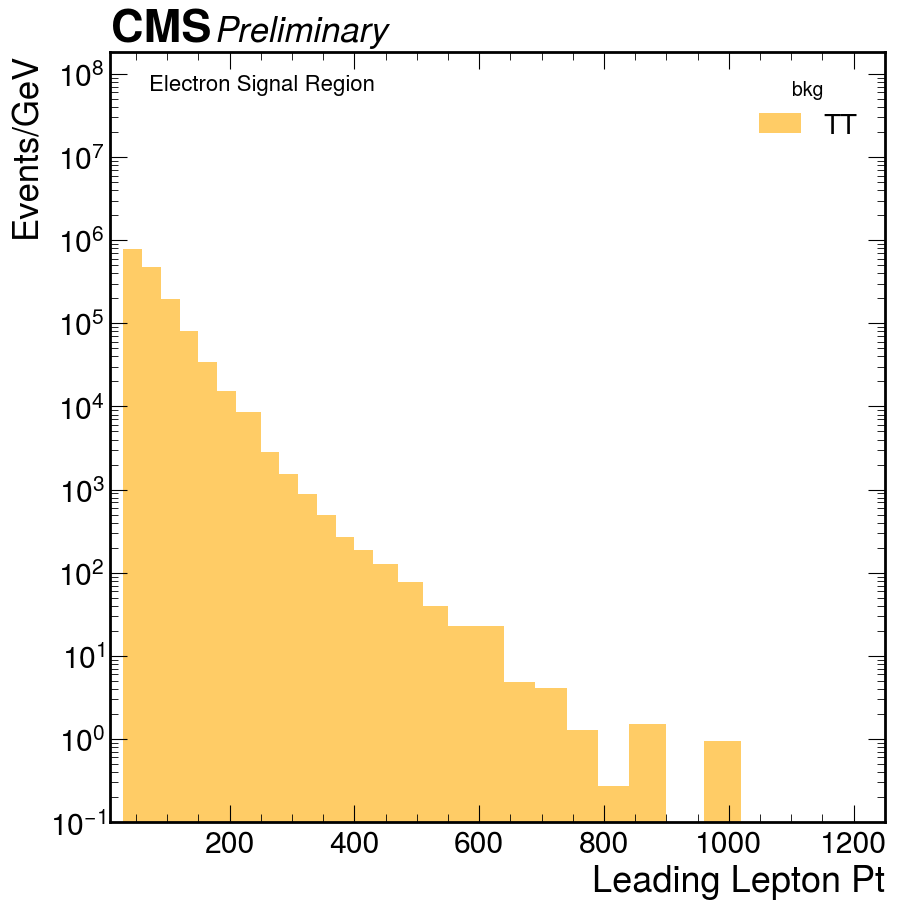

Regions: msr


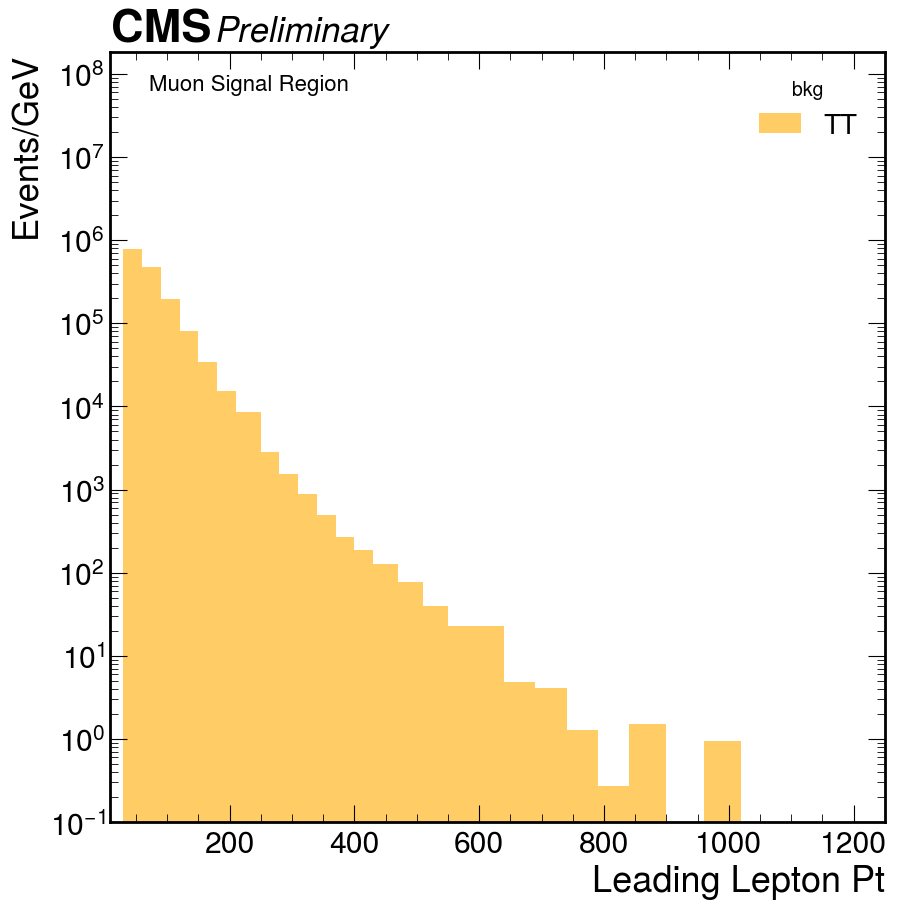

Regions: esr


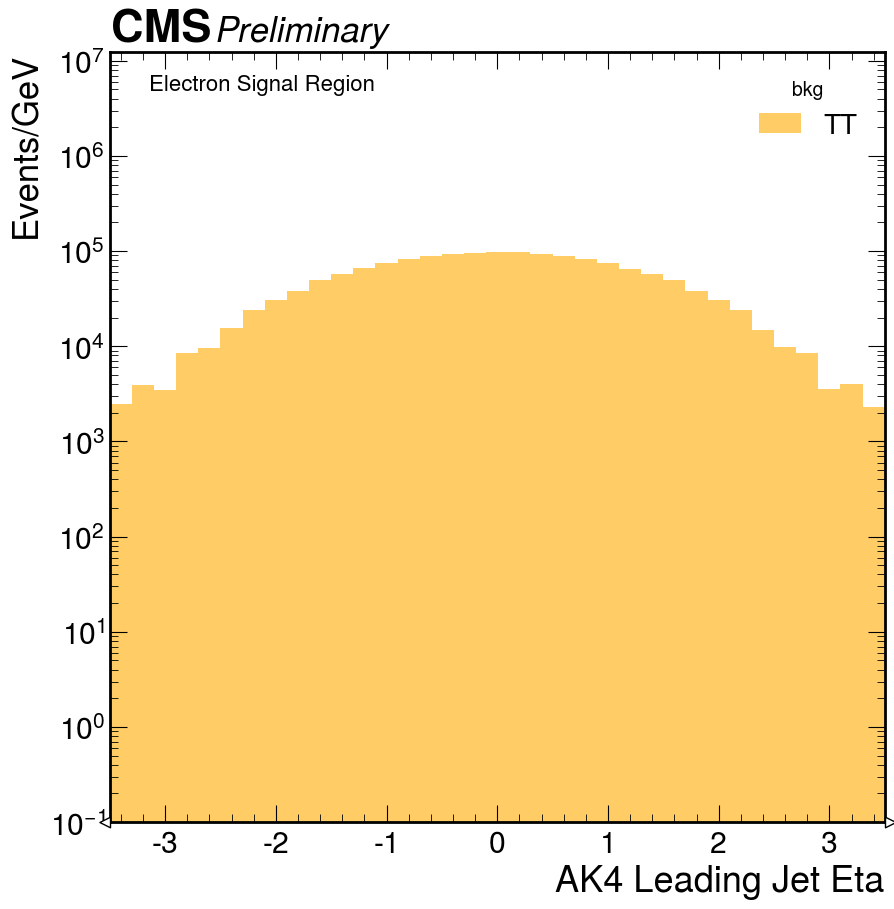

Regions: msr


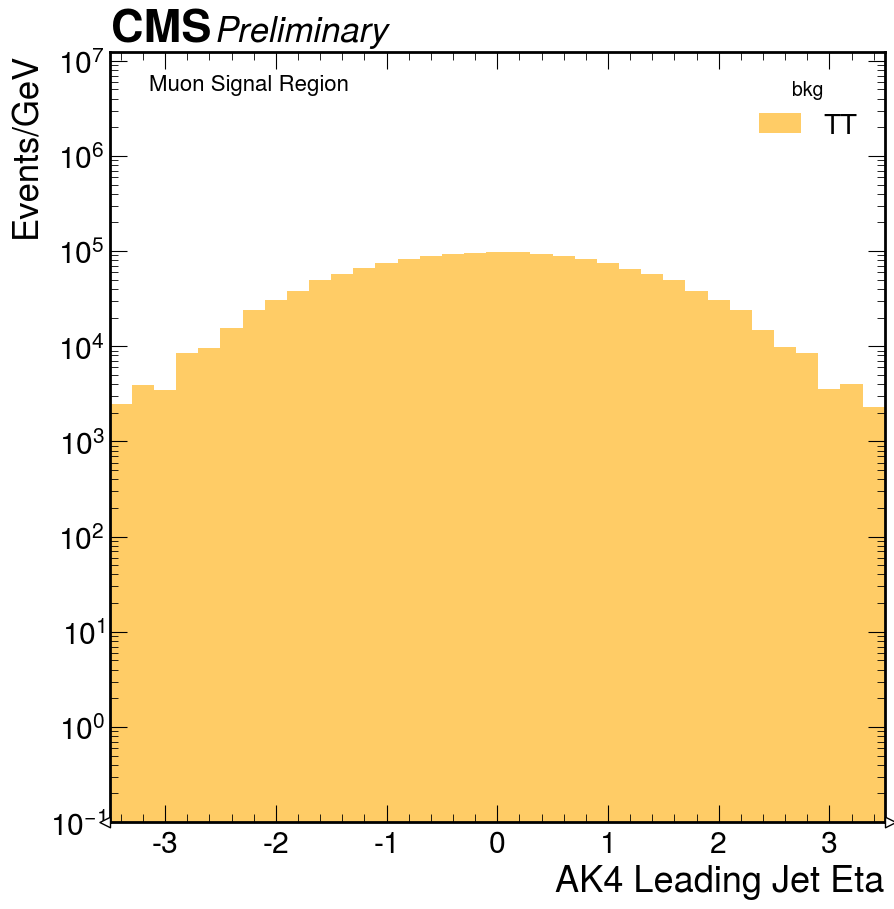

Regions: esr


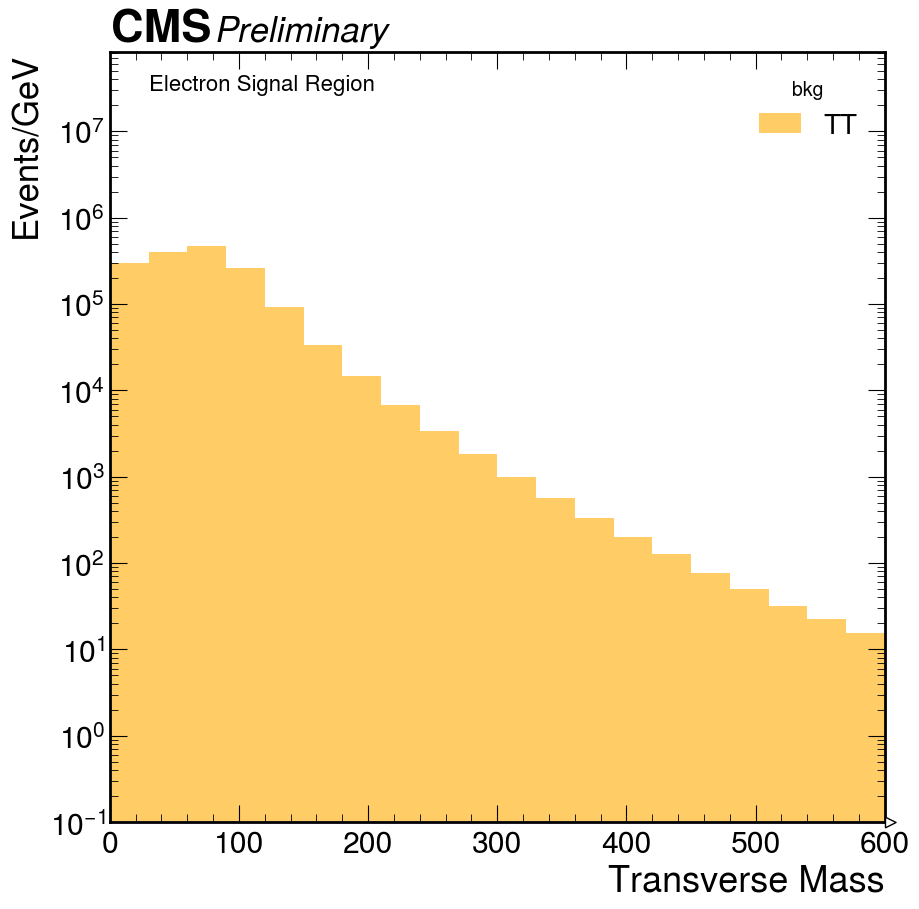

Regions: msr


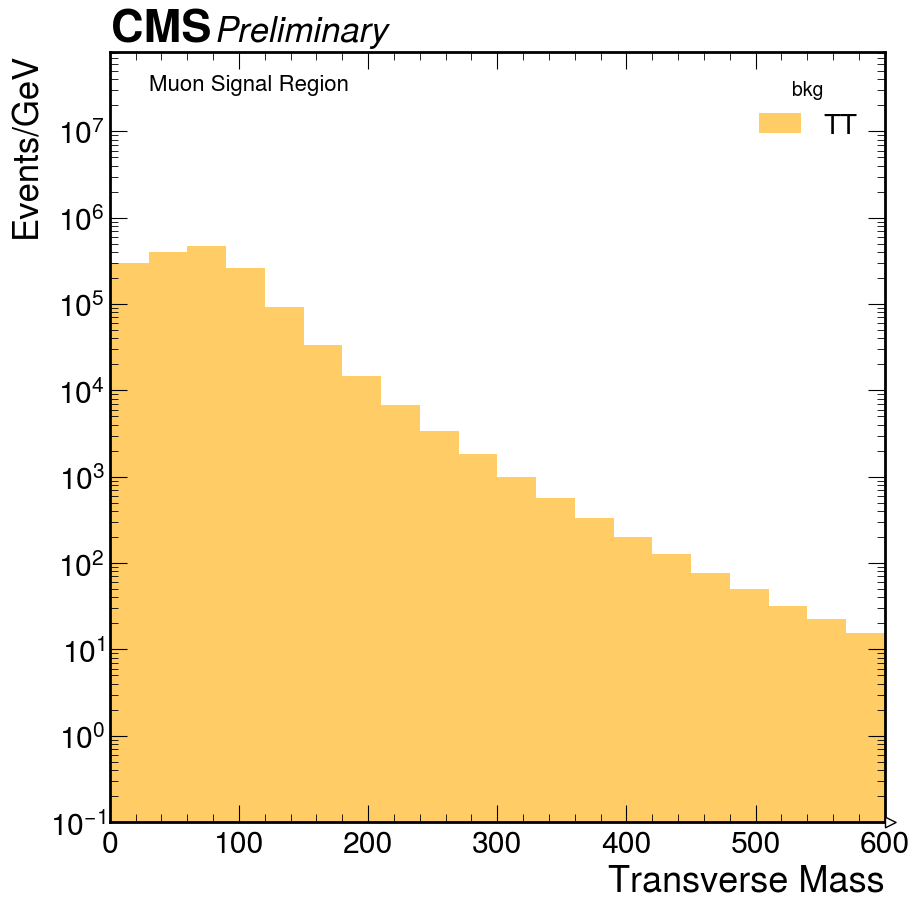

In [108]:
plot('2016preVFP', 'bkg', overlay=True)

In [104]:
new_hists = {}
for variable in bkg_hists.keys():
    if variable=='sumw': continue
    for process in bkg_hists[variable]:
        hnew = hist.Hist(
            hist.axis.StrCategory([process], name = 'process'), 
            *(ax for ax in bkg_hists[variable][process].axes), 
                storage=hist.storage.Weight())
        # fill the new histogram with the old one except for the process
        hnew.fill(ax.value )
        
        
        new_hists[variable] = hnew
        

TypeError: All axes must be accounted for in fill, you may have used a disallowed name in the axes

In [83]:
np_array = bkg_hists['j1phi']['TT'].view()

In [85]:
type(np_array)

boost_histogram._internal.view.WeightedSumView

In [121]:
bkg_hists['met']['TT'].values()[0]


array([1.37763681e+05, 3.33262156e+05, 3.70151105e+05, 3.02122423e+05,
       2.10553161e+05, 1.34111418e+05, 8.20866824e+04, 4.87502319e+04,
       2.89340402e+04, 1.73540770e+04, 1.04484183e+04, 6.44997050e+03,
       4.09026426e+03, 2.65352685e+03, 1.70939563e+03, 1.18541205e+03,
       8.03785741e+02, 5.60002243e+02, 3.96398115e+02, 2.87623964e+02,
       2.06179610e+02, 1.57851379e+02, 1.10057486e+02, 8.80027957e+01,
       7.34767774e+01, 5.27041721e+01, 4.07103639e+01, 3.30768691e+01,
       2.66636373e+01, 1.78697290e+01])

In [119]:
bkg_hists['met']['TT'].values()[1]


array([2.14674209e+05, 5.29046582e+05, 6.01814520e+05, 5.01206713e+05,
       3.53027004e+05, 2.25680302e+05, 1.36950193e+05, 8.09710060e+04,
       4.75591785e+04, 2.78937577e+04, 1.65784172e+04, 1.01299344e+04,
       6.31482809e+03, 4.01042962e+03, 2.62424923e+03, 1.74801146e+03,
       1.16742283e+03, 8.25398017e+02, 5.74884737e+02, 4.13785909e+02,
       2.89590224e+02, 2.10938699e+02, 1.65569863e+02, 1.25698968e+02,
       1.00236796e+02, 7.03164610e+01, 5.93123054e+01, 4.95934288e+01,
       3.68882862e+01, 2.55076508e+01])

In [69]:
import hist

def group(h: hist.Hist, oldname: str, newname: str, grouping: dict[str, list[str]]):
    hnew = hist.Hist(
        hist.axis.StrCategory(grouping, name=newname),
        *(ax for ax in h.axes if ax.name != oldname),
        storage=h._storage_type,
    )
    for i, indices in enumerate(grouping.values()):
        hnew.view(flow=True)[i] = h[{oldname: indices}][{oldname: sum}].view(flow=True)

    return hnew